In [1]:
from utils import *
# import graph as grp
import gc
import copy
import time
import random

# Увод 

## Биоинформатика

## Протеини 

## Протеомика

## Масени спектрометри

## Мотивација за коришћење масених спектрометара при секвенцирању пептида

# Лекција

## Увод

## Декодирање идеалног спектра

In [2]:
class Graf:
    def __init__(self, cvorovi):
        # Cvorovi su vrednosti dobijene iz masenog spektra
        self.cvorovi = sorted(cvorovi)
        self.ivice = dict([])
        self.matrica_susedstva = np.array([np.array([np.nan] * len(self.cvorovi))] * len(self.cvorovi))
        
        # Kreiraju se ivice izmedju cvorova izmedju kojih je razlika odgovarajucih masa jednaka masi bilo koje amino kiseline
        for i in range(len(self.cvorovi)):
            s_i = self.cvorovi[i]
            self.ivice[s_i] = []
            
            for j in range(len(self.cvorovi)):
                s_j = self.cvorovi[j]
                if (s_j - s_i) in celobrojne_mase_amino_kiselina:
                    self.ivice[s_i].append((s_j, celobrojne_mase_amino_kiselina[s_j - s_i]))
                    self.matrica_susedstva[i,j] = 1
    
    def __str__(self): 
        """ Prikaz masa i njima odgovarajucih susede, koji se razlikuju za jednu amino kiselinu """
        for cvor, susedi in self.ivice.items():
            for sused in susedi:
                print(f"{cvor}->{sused[0]}: {sused[1]}")
    
    def nacrtaj(self):
        # Koristi se biblioteka sa githuba za iscrtavanje grafa, koja prihavata matricu susedstava kao parametar 
        fig, ax = plt.subplots(1,1, figsize=(30,10))
        grp.draw(self.matrica_susedstva, ax=ax, node_labels={i:x for i,x in enumerate(self.cvorovi)})

        return None

In [3]:
class Peptid:
    def __init__(self, peptid):
        self.peptid = peptid
        self.idealan_spektar = self.idealan_spektar() 
            
    def __str__(self):
        return self.peptid
    
    def __repr__(self):
        return self.peptid
    
    def __add__(self, peptid):
        return Peptid(str(self.peptid) + str(peptid))
    
    def izracunaj_prefiksne_mase(self):
        prefiksne_mase = [0]

        for amino_kiselina in self.peptid:
            prefiksne_mase.append(prefiksne_mase[-1] + amino_kiseline[amino_kiselina])

        return prefiksne_mase 
    
    def idealan_spektar(self):
        """Vraca vektor masa idealnog spektra datog peptida"""
        prefiksne_mase = self.izracunaj_prefiksne_mase()

        masa_peptida = prefiksne_mase[-1]
        sufiksne_mase = []

        for prefiksna_masa in prefiksne_mase[1:-1]:
            sufiksne_mase.append(masa_peptida - prefiksna_masa)

        return MaseniSpektar(prefiksne_mase + sufiksne_mase)
    
    def delimicno_objasnjava_spektar(self, maseni_spektar):
        return len([x for x in self.izracunaj_prefiksne_mase() if x not in maseni_spektar.spektar]) == 0
    
    def objasnjava_spektar(self, maseni_spektar):
        """ Vraca informaciju da li peptid objasnjava dati maseni spektar """
        return self.idealan_spektar.spektar == maseni_spektar.spektar

In [4]:
class MaseniSpektar:
    def __init__(self, spektar):
        """ Spektar je predstavljen vektorom detektovanih celobrojnih masa"""
        self.spektar = sorted(set([0] + spektar))
        self.roditeljska_masa = max(spektar)        
        self.graf = Graf(self.spektar)                    
    
    def __str__(self):
        return "[" + ", ".join([str(x) for x in self.spektar]) + "]"
    
    def __repr__(self):
        self.graf.nacrtaj()
        return ""
        
    def pronadji_put(self):
        """ DFS = depth-first-search """

        izvor = self.graf.cvorovi[0]
        ponor = self.graf.cvorovi[-1]

        poseceni_cvorovi = [izvor]
        poslednji_posecen_cvor = izvor
        
        putanja = [izvor]
        putanja_opisana_amino_kiselinama = []
        
        while True:
            if putanja[-1] == ponor:
                return Peptid("".join(putanja_opisana_amino_kiselinama))

            pronadjen_sused = False
            for sused, amino_kiselina in self.graf.ivice[poslednji_posecen_cvor]:
                if sused not in poseceni_cvorovi:
                    pronadjen_sused = True
                    
                    poseceni_cvorovi += [sused]
                    poslednji_posecen_cvor = sused
                    
                    putanja += [sused]
                    putanja_opisana_amino_kiselinama += [amino_kiselina]
                   
                    break

            if pronadjen_sused == False:
                putanja.pop()

                poslednji_posecen_cvor = putanja[-1]
                putanja_opisana_amino_kiselinama.pop()

            if putanja[-1] == pocetak:
                return ""
            
    def pronadji_sve_putanje(self, izvor, ponor):
        """ 
        Pronalazenje svih putanja u DAG-u moze biti vremenski zahtevno jer broj takvih putanja moze biti eksponencijalan broju masa spektra 
        """
    
        if izvor == ponor:
            return [Peptid("")]
    
        putevi = []
        for sused, amino_kiselina in self.graf.ivice[izvor]:
            putevi_od_suseda = self.pronadji_sve_putanje(sused, ponor)
            putevi += [Peptid(amino_kiselina + str(x)) for x in putevi_od_suseda]
            
        return putevi  
    
    def svi_peptidi_kandidati(self):
        return self.pronadji_sve_putanje(0, self.roditeljska_masa)
    
    def dekodiranje_idealnog_spektra(self, stampaj_kandidate=False):
        
        """ 
        Moze pametnije da se implementira, jer je generisanje svih putanja vremenski zahtevno
            -> dovoljno je da posmatramo jednu po jednu, a ne da ih generisemo sve (koristiti odsecanje) 
        """
        
        peptidi_kandidati = self.svi_peptidi_kandidati()
        for peptid in peptidi_kandidati:
            
            if stampaj_kandidate:
                print(f"Peptid kandidat: {peptid}")
                
            if peptid.objasnjava_spektar(self):   
                return peptid

        return None
    
    def dekodiranje_idealnog_spektra_sa_odsecanjem(self, stampaj_kandidate=False):
        # TODO
        # treba iterativno graditi resenje od izvora do ponora
        # vrsiti odsecanje => proverom da li parcijalno resenje potencijalno moze biti resenje
        # ako ne moze => bataliti dalje prosirenje tog resenja
        
        izvor = 0
        ponor = self.roditeljska_masa
        
        trenutni_cvor = izvor
        put = [trenutni_cvor]
        peptid = ""
        # neposeceno = copy.deepcopy(self.graf.ivice)
        redni_broj_suseda = {cvor: 0 for cvor in self.graf.cvorovi}
        # treba cuvati ivice koje su posecene, i po njima odsecati => jer one prave nekonzistentnost 

        while True:
            # print(f"put: {put}, trenutni_cvor: {trenutni_cvor}, peptid: {peptid}")
            if trenutni_cvor == ponor:
                if stampaj_kandidate:
                    print(f"Peptid kandidat: {peptid}")
                
                if Peptid(peptid).objasnjava_spektar(self):   
                    return Peptid(peptid)
            
            if not Peptid(peptid).delimicno_objasnjava_spektar(self):
                # odsecanje: ne nastavlja se dalje ovim putem :) 
                put.pop()
                peptid = peptid[:-1]
                try:
                    redni_broj_suseda[trenutni_cvor] = 0 
                    trenutni_cvor = put[-1]
                    redni_broj_suseda[trenutni_cvor] += 1
                except:
                    return None
            
            if redni_broj_suseda[trenutni_cvor] >= len(self.graf.ivice[trenutni_cvor]): 
                put.pop()
                peptid = peptid[:-1]
                try:
                    redni_broj_suseda[trenutni_cvor] = 0 
                    trenutni_cvor = put[-1]
                    redni_broj_suseda[trenutni_cvor] += 1
                except:
                    return None
            else:
                sused_masa, sused_amino_kiselina = self.graf.ivice[trenutni_cvor][redni_broj_suseda[trenutni_cvor]]
                put.append(sused_masa)
                peptid += sused_amino_kiselina
                trenutni_cvor = sused_masa


In [5]:
maseni_spektar = Peptid("GPFNALGDFAAREDCAGGTTAGGPFNALGDFAAREDCAGGTTAG").idealan_spektar
start = time.time()
maseni_spektar.dekodiranje_idealnog_spektra_sa_odsecanjem()
end = time.time()
print(end-start)

0.017851829528808594


In [6]:
maseni_spektar = Peptid("GPFNALGDFAAREDCAGGTTAGGPFNALGDFAAREDCAGGTTAG").idealan_spektar
start = time.time()
#maseni_spektar.dekodiranje_idealnog_spektra()
end = time.time()
print(end-start)

0.0


In [7]:
lista_masa = [0, 113, 137, 184, 268, 297, 381, 425, 496, 581, 624, 695, 752, 832, 889, 988, 1045, 1102, 1160, 1215, 1217, 1314, 1373, 1401, 1460, 1557, 1559, 1614, 1672, 1729, 1786, 1885, 1942, 2022, 2079, 2150, 2193, 2278, 2349, 2393, 2477, 2506, 2590, 2637, 2661, 2774]
spektar = MaseniSpektar(lista_masa)

[0, 113, 137, 184, 268, 297, 381, 425, 496, 581, 624, 695, 752, 832, 889, 988, 1045, 1102, 1160, 1215, 1217, 1314, 1373, 1401, 1460, 1557, 1559, 1614, 1672, 1729, 1786, 1885, 1942, 2022, 2079, 2150, 2193, 2278, 2349, 2393, 2477, 2506, 2590, 2637, 2661, 2774]


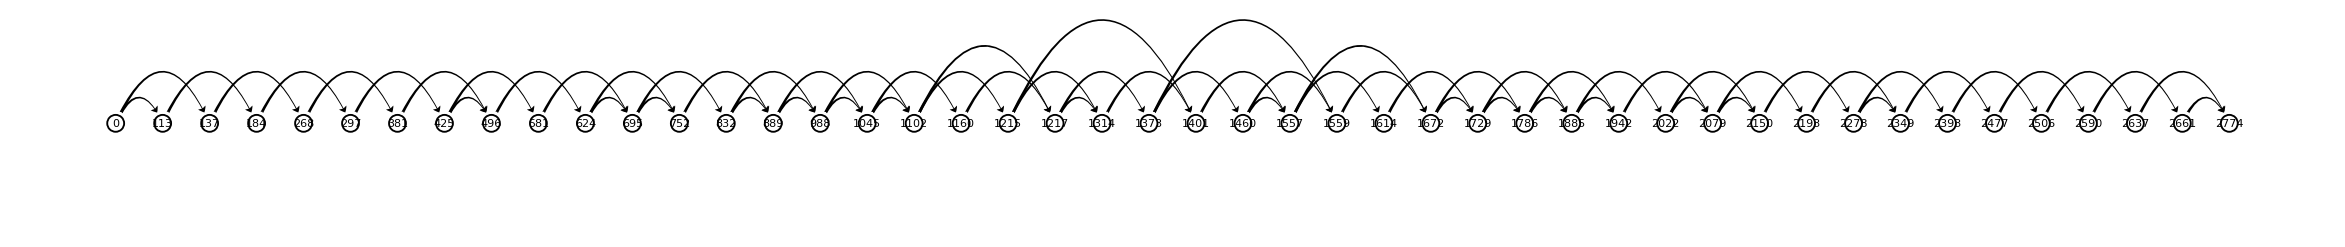

In [8]:
print(spektar)
display(spektar)

[0, 71, 156, 174, 285, 289, 400, 418, 503, 574]


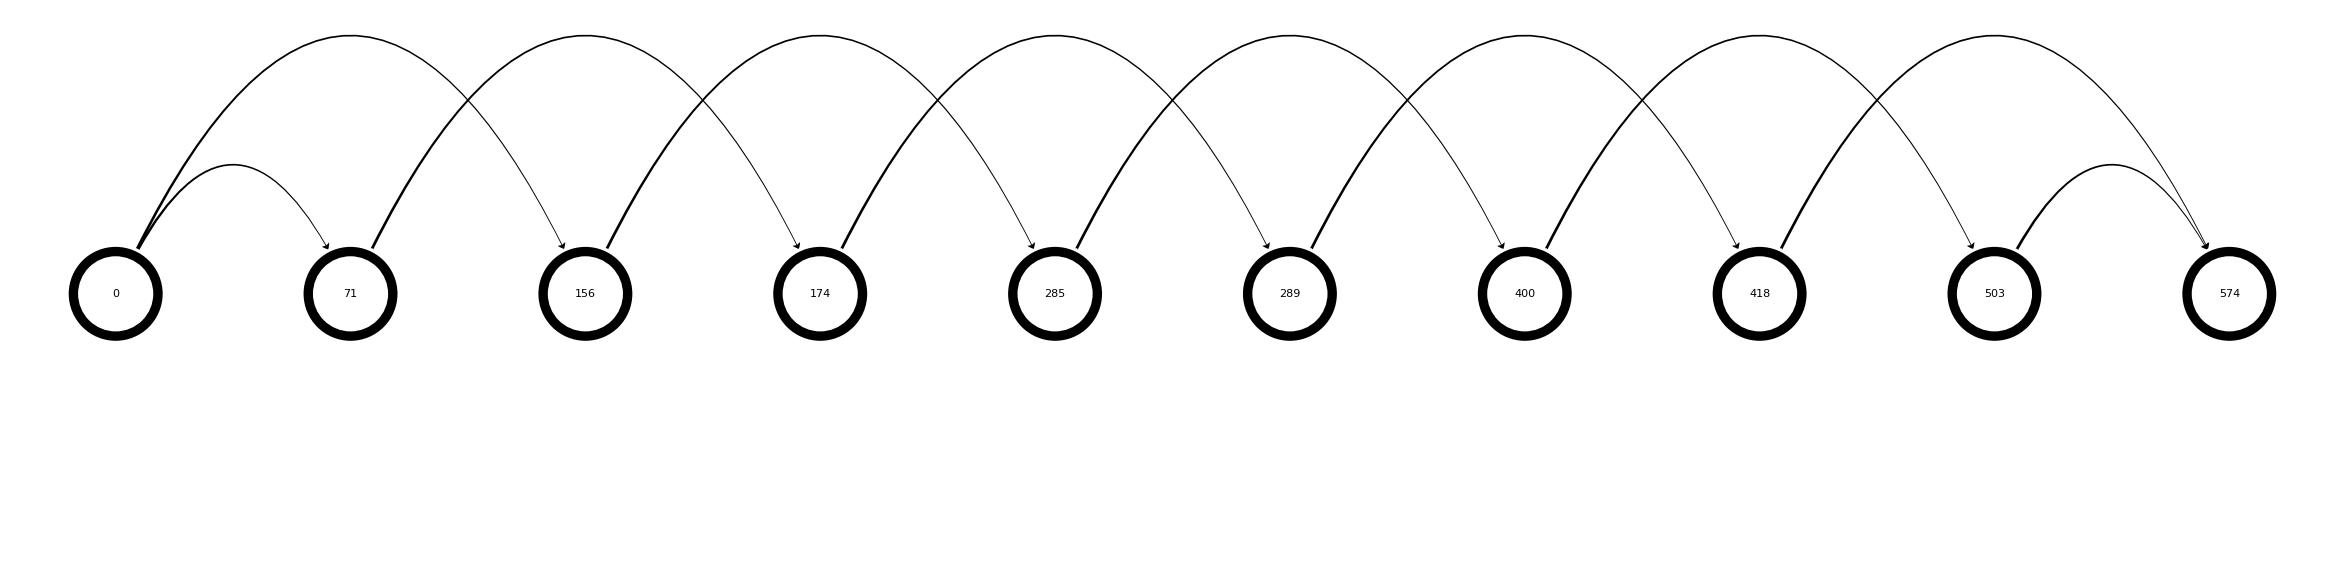

In [9]:
print(Peptid("REDCA").idealan_spektar)
display(Peptid("REDCA").idealan_spektar)

In [10]:
Peptid("REDCA").objasnjava_spektar(Peptid("REDCA").idealan_spektar)

True

#### Примери из књиге

In [11]:
maseni_spektar = Peptid("REDCA").idealan_spektar
maseni_spektar.dekodiranje_idealnog_spektra()

ACDER

In [12]:
lista_masa = [57, 71, 154, 185, 301, 332, 415, 429, 486]
display(MaseniSpektar(lista_masa).dekodiranje_idealnog_spektra())
display(MaseniSpektar(lista_masa).dekodiranje_idealnog_spektra_sa_odsecanjem())

GPFNA

GPFNA

In [13]:
lista_masa = [0, 156, 285, 400, 503, 574, 418, 289, 174, 41]
display(MaseniSpektar(lista_masa).dekodiranje_idealnog_spektra())
display(MaseniSpektar(lista_masa).dekodiranje_idealnog_spektra_sa_odsecanjem())

None

None

In [14]:
lista_masa = [0, 156, 285, 400, 503, 574, 418, 289, 174, 71]
display(MaseniSpektar(lista_masa).dekodiranje_idealnog_spektra())
display(MaseniSpektar(lista_masa).dekodiranje_idealnog_spektra_sa_odsecanjem())

ACDER

ACDER

In [15]:
lista_masa = [0, 57, 114, 128, 215, 229, 316, 330, 387, 444]
display(MaseniSpektar(lista_masa).dekodiranje_idealnog_spektra())
display(MaseniSpektar(lista_masa).dekodiranje_idealnog_spektra_sa_odsecanjem())

GGTTAG

GGTTAG

In [16]:
lista_masa = [0, 71, 103, 113, 142, 156, 170, 174, 250, 285, 289, 400, 403, 413, 432, 503, 574]
spektar = MaseniSpektar(lista_masa)
spektar.svi_peptidi_kandidati()

[AVDDCA, AVDFAA, LGDDCA, LGDFAA, REDCA, REFAA]

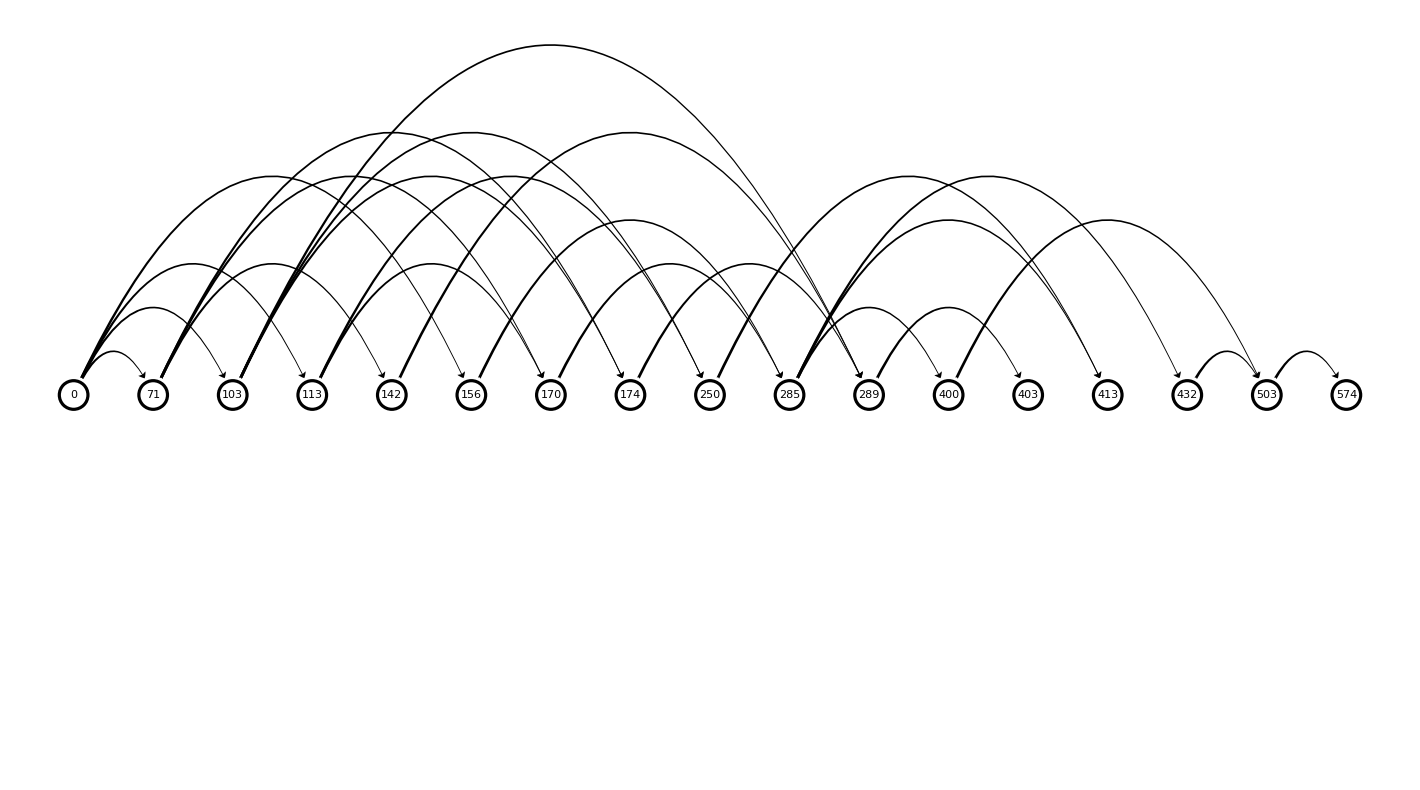

In [17]:
spektar

# Од идеалног до реалног спектра

## Секвенцирање пептида

In [18]:
""" Graf ce predstavljati spektralni vektor, a ne same vrednosti spektra, pa u zavisnosti od toga, implementacija moze zahtevati izmene """

_ = """
class Graf:
    def __init__(self, cvorovi):
        self.cvorovi = sorted(cvorovi)
        self.ivice = dict([])
        
        for s_i in self.cvorovi:
            self.ivice[s_i] = []
            
            for s_j in self.cvorovi:
                if (s_j - s_i) in mase:
                    self.ivice[s_i].append((s_j, mase[s_j - s_i]))
    
    def __str__(self): 
        for cvor, susedi in self.ivice.items():
            for sused in susedi:
                print(f"{cvor}->{sused[0]}: {sused[1]}")
    
    def nacrtaj(self):
        pass
"""

In [19]:
class Peptid:
    def __init__(self, peptid):
        self.peptid = peptid
        for atribut in ["masa", "prefiksi", "sufiksi", "vektor_prefiksnih_masa", "vektor_sufiksnih_masa", "peptidni_vektor"]:
            setattr(self, atribut, getattr(self, "_" + atribut)())
                    
    def __str__(self):
        return self.peptid
    
    def __repr__(self):
        return self.peptid
    
    def __add__(self, drugi_peptid):
        return Peptid(str(self.peptid) + str(drugi_peptid))
    
    def __lt__(self, drugi_peptid):
        return self.peptid < drugi_peptid.peptid
    
    def __le__(self, drugi_peptid):
        return self.peptid <= drugi_peptid.peptid
    
    def __eq__(self, drugi_peptid):
        return self.peptid == drugi_peptid.peptid
    
    def __ne__(self, drugi_peptid):
        return self.peptid != drugi_peptid.peptid
    
    def __gt__(self, drugi_peptid):
        return self.peptid > drugi_peptid.peptid
    
    def __ge__(self, drugi_peptid):
        return self.peptid >= drugi_peptid.peptid
    
    def __hash__(self):
        return self.peptid.__hash__()
    
    def __len__(self):
        return len(self.peptid)
    
    def _masa(self):
        masa = 0

        for i in range(len(self.peptid)):
            masa += amino_kiseline[self.peptid[i]]
            # masa += amino_kiseline_monoizotopske[self.peptid[i]] 
            # masa += amino_kiseline_srednje[self.peptid[i]]
            
        return int(masa)

    def _prefiksi(self):
        prefiksi = []
        
        for i in range(len(self.peptid)):
            prefiksi.append(self.peptid[:i+1])
            
        return prefiksi
    
    def _sufiksi(self):
        sufiksi = []
        
        for i in range(len(self.peptid)):
            sufiksi.append(self.peptid[i:])
            
        return sufiksi
    
    def _vektor_prefiksnih_masa(self):
        masa_prefiksa = 0
        vektor = [masa_prefiksa]

        for i in range(len(self.peptid)):
            masa_prefiksa += amino_kiseline[self.peptid[i]]
            # masa_prefiksa += amino_kiseline[self.peptid[i]]
            vektor.append(masa_prefiksa)

        return vektor
    
    def _vektor_sufiksnih_masa(self):
        masa_sufiksa = 0
        vektor = [masa_sufiksa]

        for i in range(len(self.peptid)):
            masa_sufiksa += amino_kiseline[self.peptid[-(i+1)]]
            # masa_sufiksa += amino_kiseline_monoizotopske[self.peptid[-(i+1)]]
            vektor.append(masa_sufiksa)

        return vektor
    
    def _peptidni_vektor(self):
        vektor = [0] * (int( self.vektor_prefiksnih_masa[-1]) + 1)

        for prefiksna_masa in  self.vektor_prefiksnih_masa:
            vektor[int(prefiksna_masa)] = 1

        return vektor
    
    def peptidni_vektor_u_peptid(clf, vektor):
        prefiksne_mase = [i+1 for i, masa in enumerate(vektor) if masa]
        sekvenca_amino_kiselina = prefiksne_mase - np.concatenate(([0], prefiksne_mase[:-1]))

In [356]:
class MaseniSpektar:
    # spektar je sad dvodimenziona struktura (nisu vise samo mase): m_z, intenzitet
    
    def __init__(self, spektar):
        self.mase_intenziteti = spektar
        self.m_z = sorted(list(spektar["m_z"].astype('int64')))
        self.intenziteti = list(spektar["intenzitet"])        
        self.spektralni_vektor = self._spektralni_vektor()
        
    def __str__(self):
        return None 
    
    def _spektralni_vektor(self):
        vektor = [0] * (self.m_z[-1] + 1)
        
        for i in range(len(self.m_z)):
            vektor[self.m_z[i]] = self.intenziteti[i]

        return vektor
    
    def nacrtaj(self):
        fig, ax = plt.subplots(figsize=(30, 10))
        # podesiti width i linewidth
        ax.bar(self.m_z, height=self.intenziteti, width=1, linewidth=1)
        oznake_pikova = [self.m_z[i] if self.intenziteti[i] >= 50 else 0 for i in range(len(self.intenziteti))]

        for indeks, oznaka in enumerate(list(oznake_pikova)):
            if oznaka != 0:
                ax.annotate(oznaka, (self.m_z[indeks] - 10, self.intenziteti[indeks] + 20))

        plt.show()

    
    @property
    def grafovska_reprezentacija(self):
        # na osnovu spektralnog vektora
        return None

In [357]:
class MaseniSpektrometar:
    
    def __init__(trening_skup_spektara):
        self.treniraj_parametre()
    
    def treniraj_parametre():
        # Nije implementirano: Trenutno u razvoju izvan klasa
        self.tipovi_fragmentnih_jona = []
        self.pragovi_intenziteta = []
        
        return None

## Проблеми са неадекватним скорингом

In [358]:
def skor_sabiranjem_intenziteta(peptid, spektar):
    """ intensity_count """
    return np.dot(peptid.peptidni_vektor, spektar.spektralni_vektor)

def skor_prebrojavanje_visokih_pikova(peptid, spektar, prag):
    pripremljen_spektralni_vektor = np.array([x if x >= prag else 0 for x in spektar.spektralni_vektor])
    return len([x for x in peptid.peptidni_vektor * pripremljen_spektralni_vektor if x != 0])

In [359]:
skor_sabiranjem_intenziteta(
    peptid=Peptid("REDCA"), 
    spektar=MaseniSpektar(pd.DataFrame(zip([0, 156, 285, 400, 503, 574], [10, 10, 10, 10, 10, 10]), columns=["m_z","intenzitet"]))
)

60

In [360]:
skor_sabiranjem_intenziteta(
    peptid=Peptid("REDCA"),               
    spektar=MaseniSpektar(pd.DataFrame(zip([0, 71, 156, 174, 290, 289, 503, 574], [5, 5, 100, 5, 5, 5, 5, 100]), columns=["m_z","intenzitet"]))
)

210

In [361]:
skor_prebrojavanje_visokih_pikova(
    peptid=Peptid("REDCA"),
    spektar=MaseniSpektar(pd.DataFrame(zip([0, 156, 285, 400, 503, 574], [10, 10, 10, 10, 10, 10]), columns=["m_z","intenzitet"])),
    prag=10
)

6

In [362]:
skor_prebrojavanje_visokih_pikova(
    peptid=Peptid("REDCA"), 
    spektar=MaseniSpektar(pd.DataFrame(zip([0, 71, 156, 174, 290, 289, 503, 574], [5, 5, 100, 5, 5, 5, 5, 100]), columns=["m_z","intenzitet"])),
    prag=10
)

2

Претходна два приступа су проблематична (објаснити), због чега се уводи спектрални вектор као појам.

## Skorovanje putanja spektralnog grafa

<pre>
    <b>p(P,S)</b> - verovatnoca da peptid P proizvodi spektar S
    <b>Cilj:</b> naci peptid P koji maksimizuje p(P,S) za dati spektar S
    
Tandem maseni spektar se karakterise skupom tipova jona D = {d1, ..., dk} i njihovim verovatnocama {p(d1),..., p(dk)}, takvim da se di-joni parcijalnog peptida proizvode <b>nezavisno</b> sa verovatnocama p(di).

Maseni spektar takodje proizvodi i <b>slucajan sum</b>, koji u bilo kojoj poziciji moze generisati pik sa verovatnocom qr. 

=> Pik na poziciji koja odgovara di-jonu je generisan sa verovatnocom qi = p(di) + (1-p(di))*qr
=> To moze biti procenjeno iz date empirijske distribucije (<b> graficki prikazano iznad pomocu histogramima po rangovima</b>)

</pre>

<pre>

Parcijalni peptid moze teorijski imat ido k odgovarajucih pikova spektra. Ima svih k pikova sa verovatnocom Proizvod(i=1,k) qi, i nema pikova sa verovatnovom Proizvod(i=1,k)(1-qi). 

<b>Pretpostavimo</b>:
- parcijalni peptid kandidata Pi proizvodi jone d1,...,dl (prisutni joni) i ne proizvodi jone dl+1,...,dk (nedostajuci joni) u spektru.
Ovih l prisutnih jona ce rezultaovati cvorom u spektralnom grafu koji odgovara Pi. Kako da skorujemo ovaj cvor?
<ul>
<li> premium for explained ions 
<li> penalty for unexplained ions
</ul>

=> To znaci da skor ovog cvora treba da bude proporcionalan sa q1,...,ql, ili mozda sa q1/qr,...,ql/qr, radi normalizacije verovatnoca u odnosu na hemijski i elektricni sum
</pre>

# Поједностављени пример масеног спектра

<pre>
Амино киселине: 
mass(x) = 3
mass(y) = 4
mass(z) = 6
</pre>

# Generisanje vestackog primera:

<pre>
chicken podaci: 
    broj spektara: 3125, broj razlicitih peptida: 1798
    minimalna duzina peptida: 5, maksimalna duzina peptida: 46
    srednja vrednost broja razlicitih spektara po peptidu: 1.7380422691879867, medijana broja razlicitih spektara po peptidu: 1.0, maksimalna vrednost broja razlicitih spektara po peptidu: 15
    minimalan_intenzitet: 10.0, maksimalan_intenzitet: 10000.0
</pre>

<pre>
1. generisi_slucajan_peptid
    duzine koja odgovara stvarnosti, neka bude od 10 do 15 (moze se istraziti kroz primere stvarnih spektara koje su to vrednosti)

</pre>

In [363]:
pojednostavljen_skup_amino_kiselina = {
    "X":3,
    "Y":4,
    "Z":6
}

<pre>

percentili intenziteta (10,25,50,75,90)
    10% 54.0
    25% 119.0
    50% 301.0
    75% 794.0
    90% 2045.0

duzine peptida: 
    minimalna = 5
    maksimalna = 46

intenzitet spektra:
    minimalan: 10.0
    maksimalan: 10000.0
    
broj spektara: 3125
broj razlicitih peptida: 1798

srednja vrednost broja razlicitih spektara po peptidu: 1.7380422691879867
medijana broja razlicitih spektara po peptidu: 1.0
maksimalna vrednost broja razlicitih spektara po peptidu: 15
</pre>


In [364]:
prefiks_fragmentni_jon_celobrojnog_pomeraja = {
    1:"b",
    17:"b-h2o",
    -27:"a",
    -16:"b-nh3",
    -35:"b-h2o-h2o"
}
 
sufiks_fragmentni_jon_celobrojnog_pomeraja = {
    19:"y",    
    1:"y-h2o",
    2:"y-nh3",
}

In [376]:
class TreningSkup:

    def __init__(self, peptidi_i_spektri):
        self.peptidi_i_spektri = peptidi_i_spektri
    
    @classmethod
    def pomocna_funkcija_ucestalosti(cls, peptidne_mase, spektralne_mase, naelektrisanje):
        pomeraji = []

        for Pi in peptidne_mase:
            for sj in spektralne_mase:
                pomeraji.append(Pi - naelektrisanje * sj)

        return pomeraji
   
    def funkcija_ucestalosti_pomeraja(self, naelektrisanja, prefiks):
        fig, axs = plt.subplots(len(naelektrisanja), 1, figsize=(50, len(naelektrisanja)*10))
       
        axs = axs if len(naelektrisanja) != 1 else [axs]
       
        for i, naelektrisanje in enumerate(naelektrisanja):
            pomeraji = []

            for (peptid, spektar) in self.peptidi_i_spektri:
                peptidne_mase = peptid.vektor_prefiksnih_masa if prefiks else peptid.vektor_sufiksnih_masa
                pomeraji += TreningSkup.pomocna_funkcija_ucestalosti(peptidne_mase, spektar.m_z, naelektrisanje)

            axs[i].hist(pomeraji, bins=np.arange(-50, 50, 1), density=True, stacked=True, align='left')
            axs[i].set_xticks(np.arange(-50, 50, 1))
            axs[i].set_title(f"naelektrisanje={naelektrisanje}; {'prefiksi' if prefiks else 'sufiksi'}")

        plt.show()        
   
    def funkcija_ucestalosti_pomeraja_po_grupama_intenziteta(self, naelektrisanje, prefiks):   
        
        pomeraji = dict({})

        for i in range(len(trening_skup.peptidi_i_spektri)):
            grupe = dict({})

            peptid, spektar = trening_skup.peptidi_i_spektri[i]
            sortirani_spektar = spektar.mase_intenziteti.sort_values(by="intenzitet", ascending=False)

            peptidne_mase = peptid.vektor_prefiksnih_masa if prefiks else peptid.vektor_sufiksnih_masa

            # K = len(trening_skup.peptidi_i_spektri[i][1].intenziteti)//5
            K = trening_skup.peptidi_i_spektri[i][0].masa // 100
            broj_rangova = len(sortirani_spektar) // K + 1 

            for j in range(0, broj_rangova):
                grupe[j] = sortirani_spektar.iloc[j*K:(j+1)*K]

            for j in range(0, broj_rangova):
                if len(grupe.items()) > j:
                    pomeraji[j] = pomeraji.get(j, []) + TreningSkup.pomocna_funkcija_ucestalosti(peptidne_mase, list(grupe[j].m_z.values), naelektrisanje)        

        broj_rangova = len(pomeraji)  # + 1 
        fig, axs = plt.subplots(broj_rangova, 1, figsize=(50, 15*broj_rangova))

        for k in range(broj_rangova):
            pomeraji_manji_od_k = [x for i in range(0, k) for x in pomeraji.get(i, [])]
            pomeraji_veci_jednaki_od_k = [x for i in range(k, broj_rangova) for x in pomeraji.get(i,[])]

            histogram_manjih = np.histogram(pomeraji_manji_od_k, bins=np.arange(-40, 40, 1))
            histogram_vecih = np.histogram(pomeraji_veci_jednaki_od_k, bins=np.arange(-40, 40, 1))

            const = 0.5
            x = np.concatenate((const*(histogram_manjih[1][1:] + histogram_manjih[1][:-1]), const*(histogram_vecih[1][1:] + histogram_vecih[1][:-1])))
            x = [i-const for i in x]
            y = np.concatenate((histogram_manjih[0] * -1, histogram_vecih[0]))

            broj_oznaka = len(histogram_manjih[1])
            axs[k].bar(x=x, height=y, width=1, align='center')
            oznake_pikova = [prefiks_fragmentni_jon_celobrojnog_pomeraja.get(-1 * int(i), '') if prefiks else sufiks_fragmentni_jon_celobrojnog_pomeraja.get(-1 * int(i), '') for i in x[broj_oznaka:]]

            for indeks, oznaka in enumerate(list(oznake_pikova)):
                if oznaka != '':
                    axs[k].annotate(oznaka, (x[broj_oznaka+indeks], y[broj_oznaka+indeks] + 100), fontsize='large', ha='center')

            axs[k].set_xticks(np.arange(-41, 41, 1))
            axs[k].set_yticks(np.arange(
                  int(np.ceil((-1 * max([abs(i) for i in y]) - 1000)/1000)*1000), 
                  max([abs(i) for i in y]) + 1000,
                  1000
                )
             )
            axs[k].set_ylim(-1 * max([abs(i) for i in y]) - 1000, max([abs(i) for i in y]) + 1000)
            axs[k].axhline(y=0, xmin=0, xmax=1, color="black")
            axs[k].set_title(f"rang >= {k+1}, rang < {k+1}")

        plt.show()

In [377]:
def generisi_slucajan_peptid():
    return "".join([random.choice(list(amino_kiseline.keys())) for i in range(max(8,int(abs(np.random.normal(15, 10)))))])

celobrojni_pomeraj_fragmentnih_jona = {
    "y": 19,
    "b": 1, 
    "b-h2o": 17,
    "y-h2o": 1,
    "a": -27,
    "b-nh3": -16,
    "y-nh3": 2,
    "b-h2o-h2o": -35,
    #"b-h2o-nh3": 0.,
    #"a-nh3": 0.1473,
    #"a-h2o": 0.1221,
    #"y2-h2o": 0.1164,
    #"y-h2o-nh3": 0.1107,
    #"y-h2o-h2o": 0.1039
}

verovatnoce_fragmentnih_jona = {
    "y": 0.6895,
    "b": 0.6484, 
    "b-h2o": 0.3858,
    "y-h2o": 0.2831,
    "a": 0.2329,
    "b-nh3": 0.1815,
    "y-nh3": 0.1495,
    "b-h2o-h2o": 0.1724,
    #"b-h2o-nh3": 0.1530,
    #"a-nh3": 0.1473,
    #"a-h2o": 0.1221,
    #"y2-h2o": 0.1164,
    #"y-h2o-nh3": 0.1107,
    #"y-h2o-h2o": 0.1039
}

# TODO: kako automatizovati reverse proces gde se donose zakljucci o svakom tipu fragment jona, i tome kolika je njegova verovatnoca u kom rangu? :D 
rangovi_intenziteta_pojavljivanja_fragmentnih_jona = {
    "y": [1,2],
    "b": [2,3], 
    "b-h2o": [4,5],
    "y-h2o": [4],
    "a": [2,3],
    "b-nh3": [5],
    "y-nh3": [1,2],
    "b-h2o-h2o": [2]
}


# pristup sa pesudo verovatnocama => a moguce je rekreirati i egzaktno, sa drugacijim pristupom
# kako bi to izgledalo? za svaki jon bi se generisao broj pikova koji treba da izgenerise itd ... ali to je kompleksnije jer se totalno menja pristup (cini mi se)
def generisi_fragmentne_jone_peptida(peptid, izabrani_joni):
    
    # 10 - 180 pikova bi trebalo da bude prisutno u masenom spektru     
    
    # joni = list(verovatnoce_fragmentnih_jona.keys())
    # verovatnoce = list(verovatnoce_fragmentnih_jona.values())
         
    fragmentni_joni_peptida = []
    
    # ne bi trebao da bude po jedan jon nego svaki jon sa odredjenom verovatnocom => mnogo vise smisla ima 
    for i in range(len(peptid)):
        prefiksna_masa_peptida = Peptid(peptid[0:i]).masa
        sufiksna_masa_peptida = Peptid(peptid[i:]).masa
        
        for jon, verovatnoca in verovatnoce_fragmentnih_jona.items():
            
            if random.random() <= verovatnoca:
            
                pomeraj = celobrojni_pomeraj_fragmentnih_jona[jon]
                # intenzitet u opsegu od 10 do 10000, u zavisnosti od verovatnoce jona i nekog random faktora :) 
                # rang = 1 => veci intenzitet ... rang = 5 => manji intenzitet
                rang = 6-random.choice(rangovi_intenziteta_pojavljivanja_fragmentnih_jona[jon])
                intenzitet = random.randint(10+(rang-1)*1998, 10+(rang)*1998)

                # sufiksni peptidi
                if np.any([jon.startswith(oznaka) for oznaka in ["x","y","z"]]):
                    if (sufiksna_masa_peptida + pomeraj) >= 91 and (sufiksna_masa_peptida + pomeraj) <= 2000:
                        fragmentni_joni_peptida.append([sufiksna_masa_peptida + pomeraj, intenzitet])

                # prefiksni peptidi
                elif np.any(jon.startswith(oznaka) for oznaka in ["a","b","c"]):
                    if (prefiksna_masa_peptida + pomeraj) >= 91 and (prefiksna_masa_peptida + pomeraj) <= 2000:
                        fragmentni_joni_peptida.append([prefiksna_masa_peptida + pomeraj, intenzitet])

    for i in range(random.randint(0, len(peptid))):
        fragmentni_joni_peptida.append(generisi_sum())
    
    return fragmentni_joni_peptida

def generisi_sum():
    # m_z koji moze biti detektovan od 91 do 2000
    m_z = random.randint(91,2000)
    intenzitet = random.randint(10, 10000)

    return (m_z, intenzitet)
        
def generisi_trening_skup(broj_peptida):
    izabrani_joni = []
    peptidi = [generisi_slucajan_peptid() for i in range(broj_peptida)]
   
    trening_skup = [
        (Peptid(peptid), MaseniSpektar(
            pd.DataFrame(generisi_fragmentne_jone_peptida(peptid, izabrani_joni), columns=["m_z","intenzitet"])))
     for peptid in peptidi
    ]
    
    return izabrani_joni, TreningSkup(trening_skup)

In [378]:
izabrani_joni, trening_skup = generisi_trening_skup(
    broj_peptida=500
)

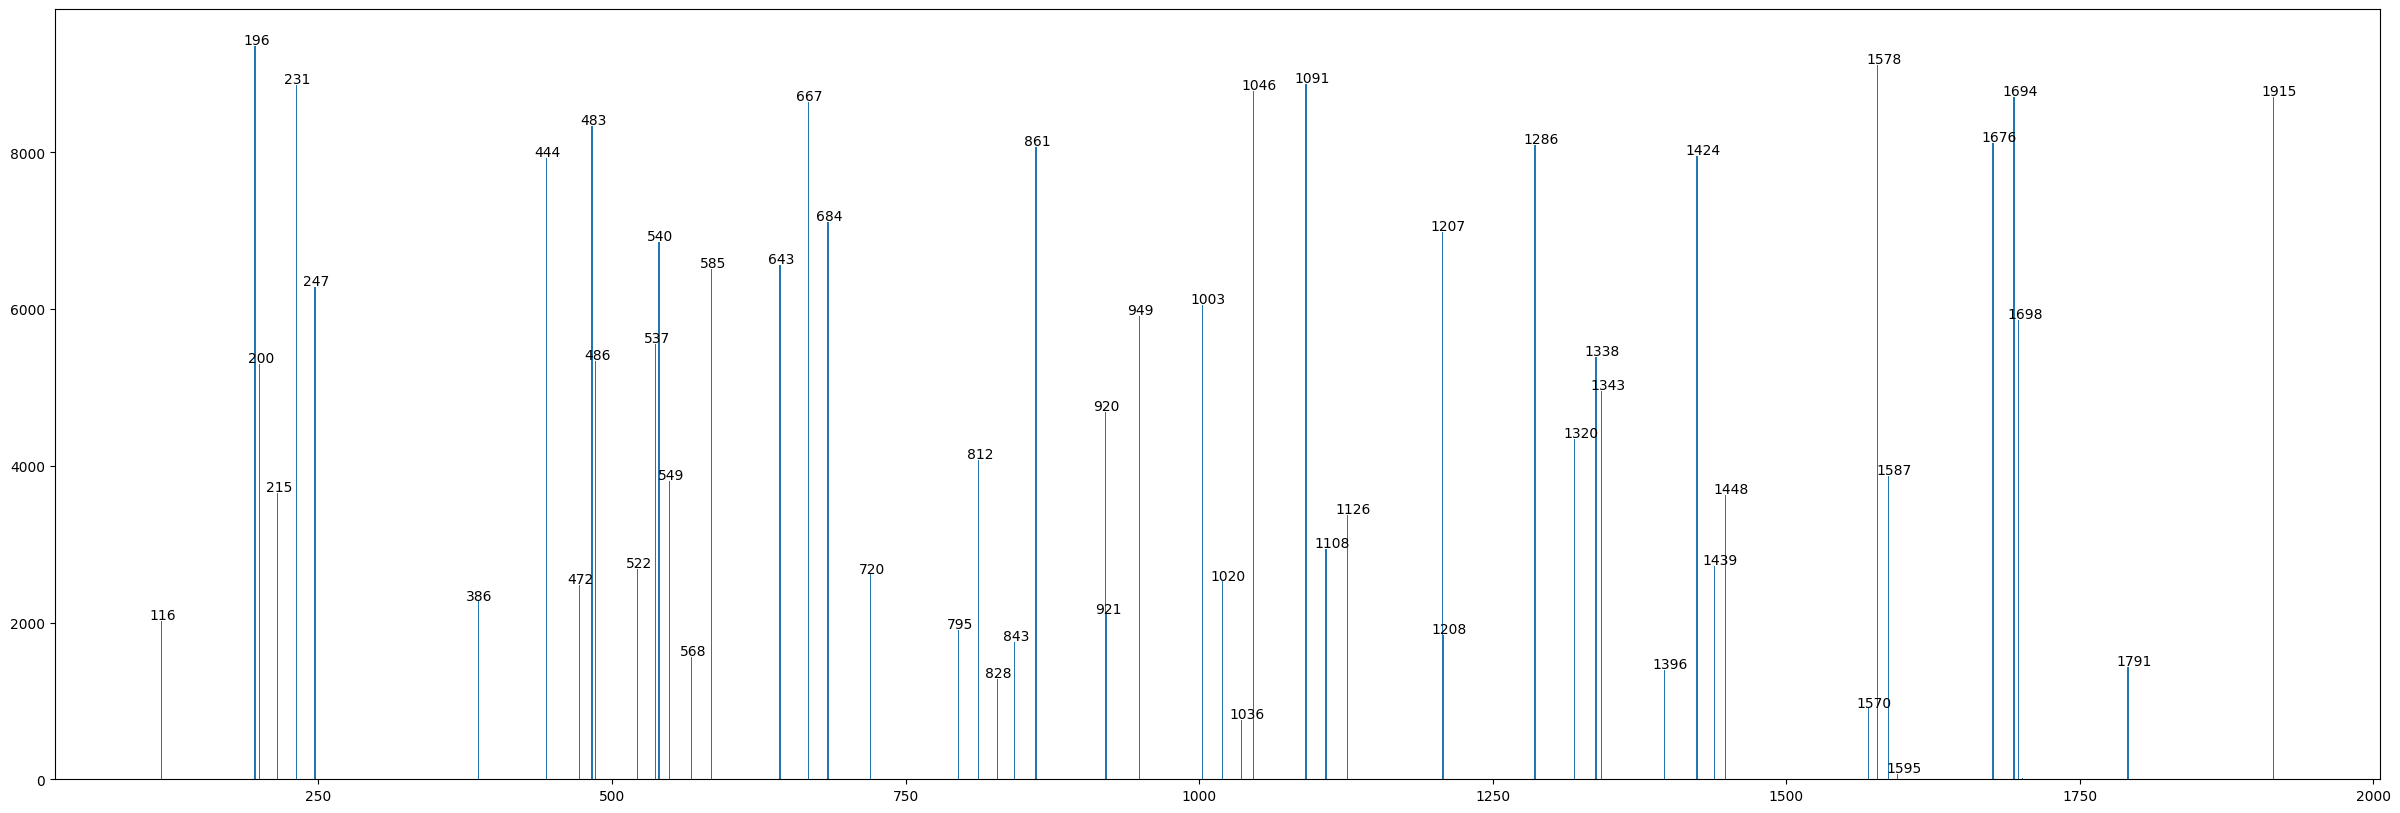

In [374]:
ms = trening_skup.peptidi_i_spektri[random.randint(1,10)-1][1].nacrtaj()

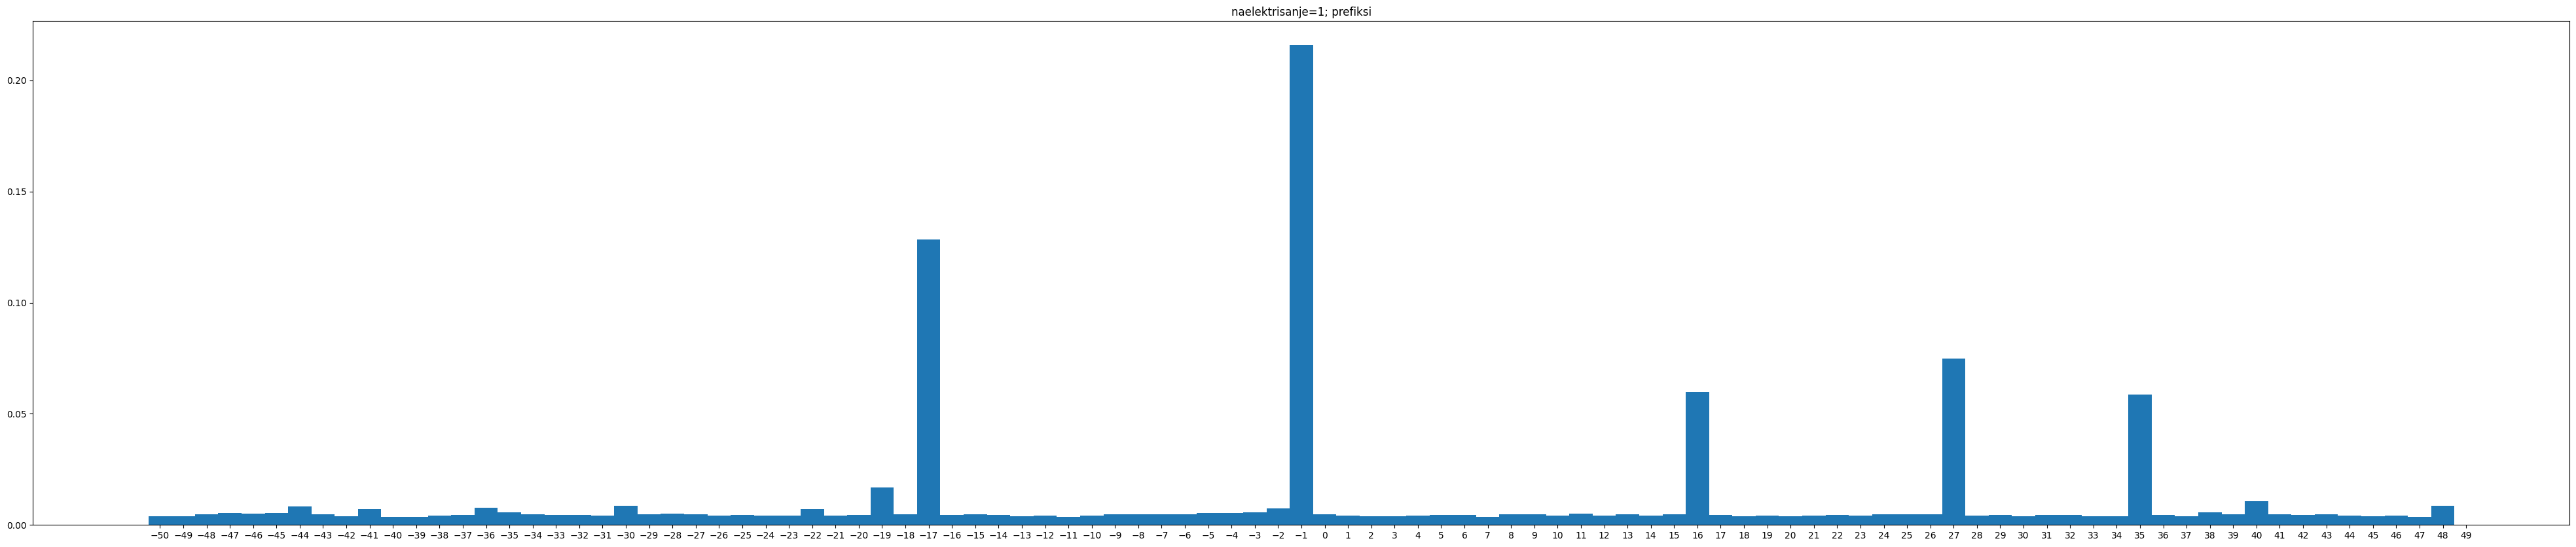

In [114]:
trening_skup.funkcija_ucestalosti_pomeraja(naelektrisanja=[1], prefiks=True)

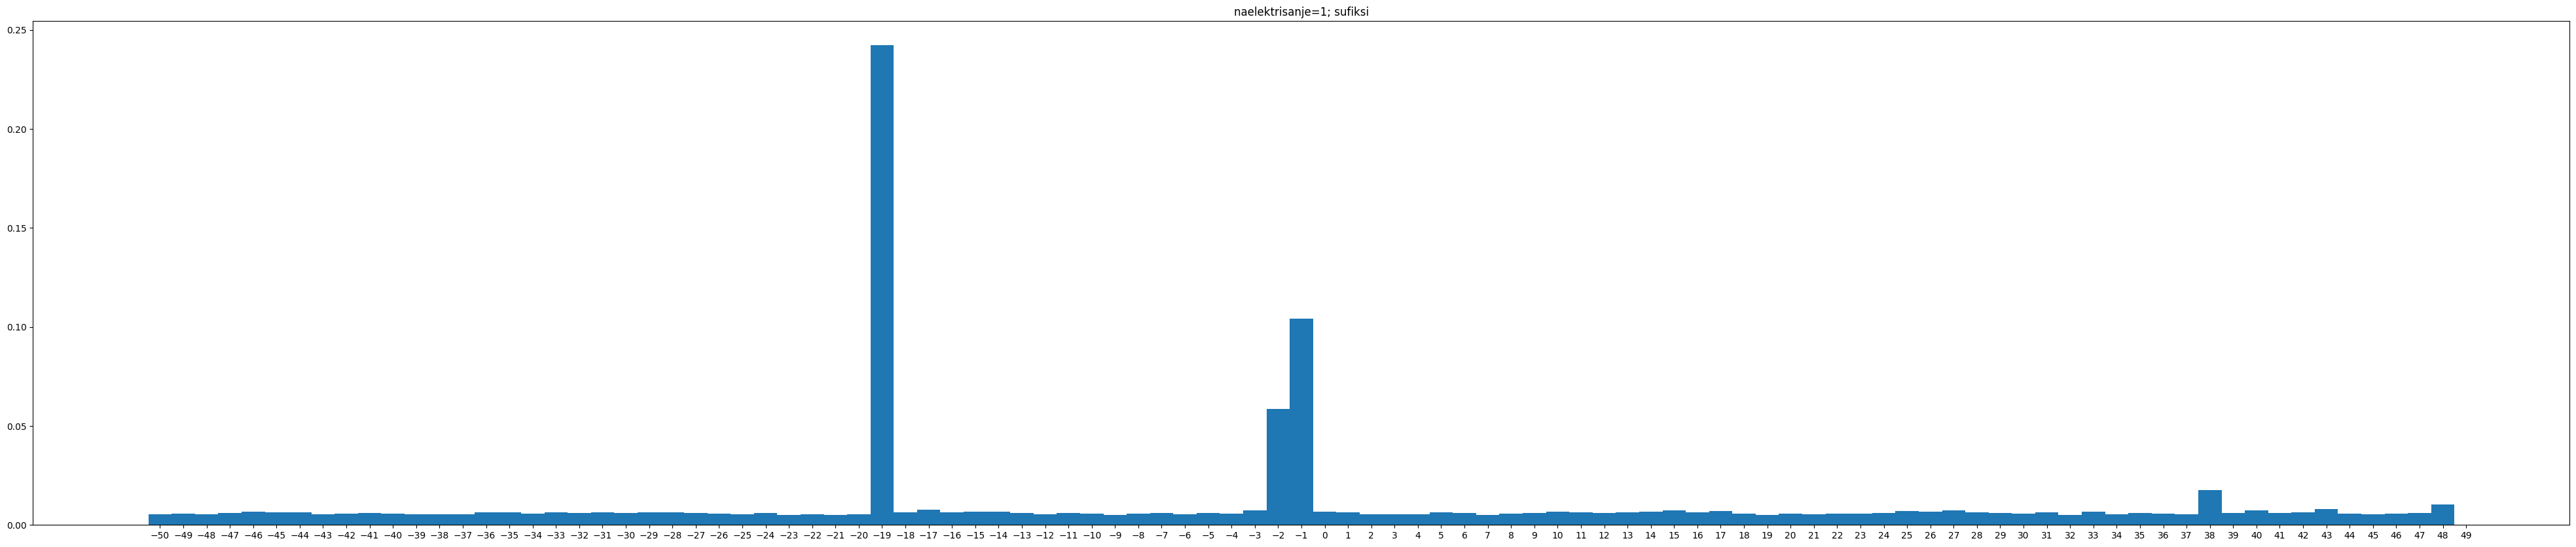

In [115]:
trening_skup.funkcija_ucestalosti_pomeraja(naelektrisanja=[1], prefiks=False)

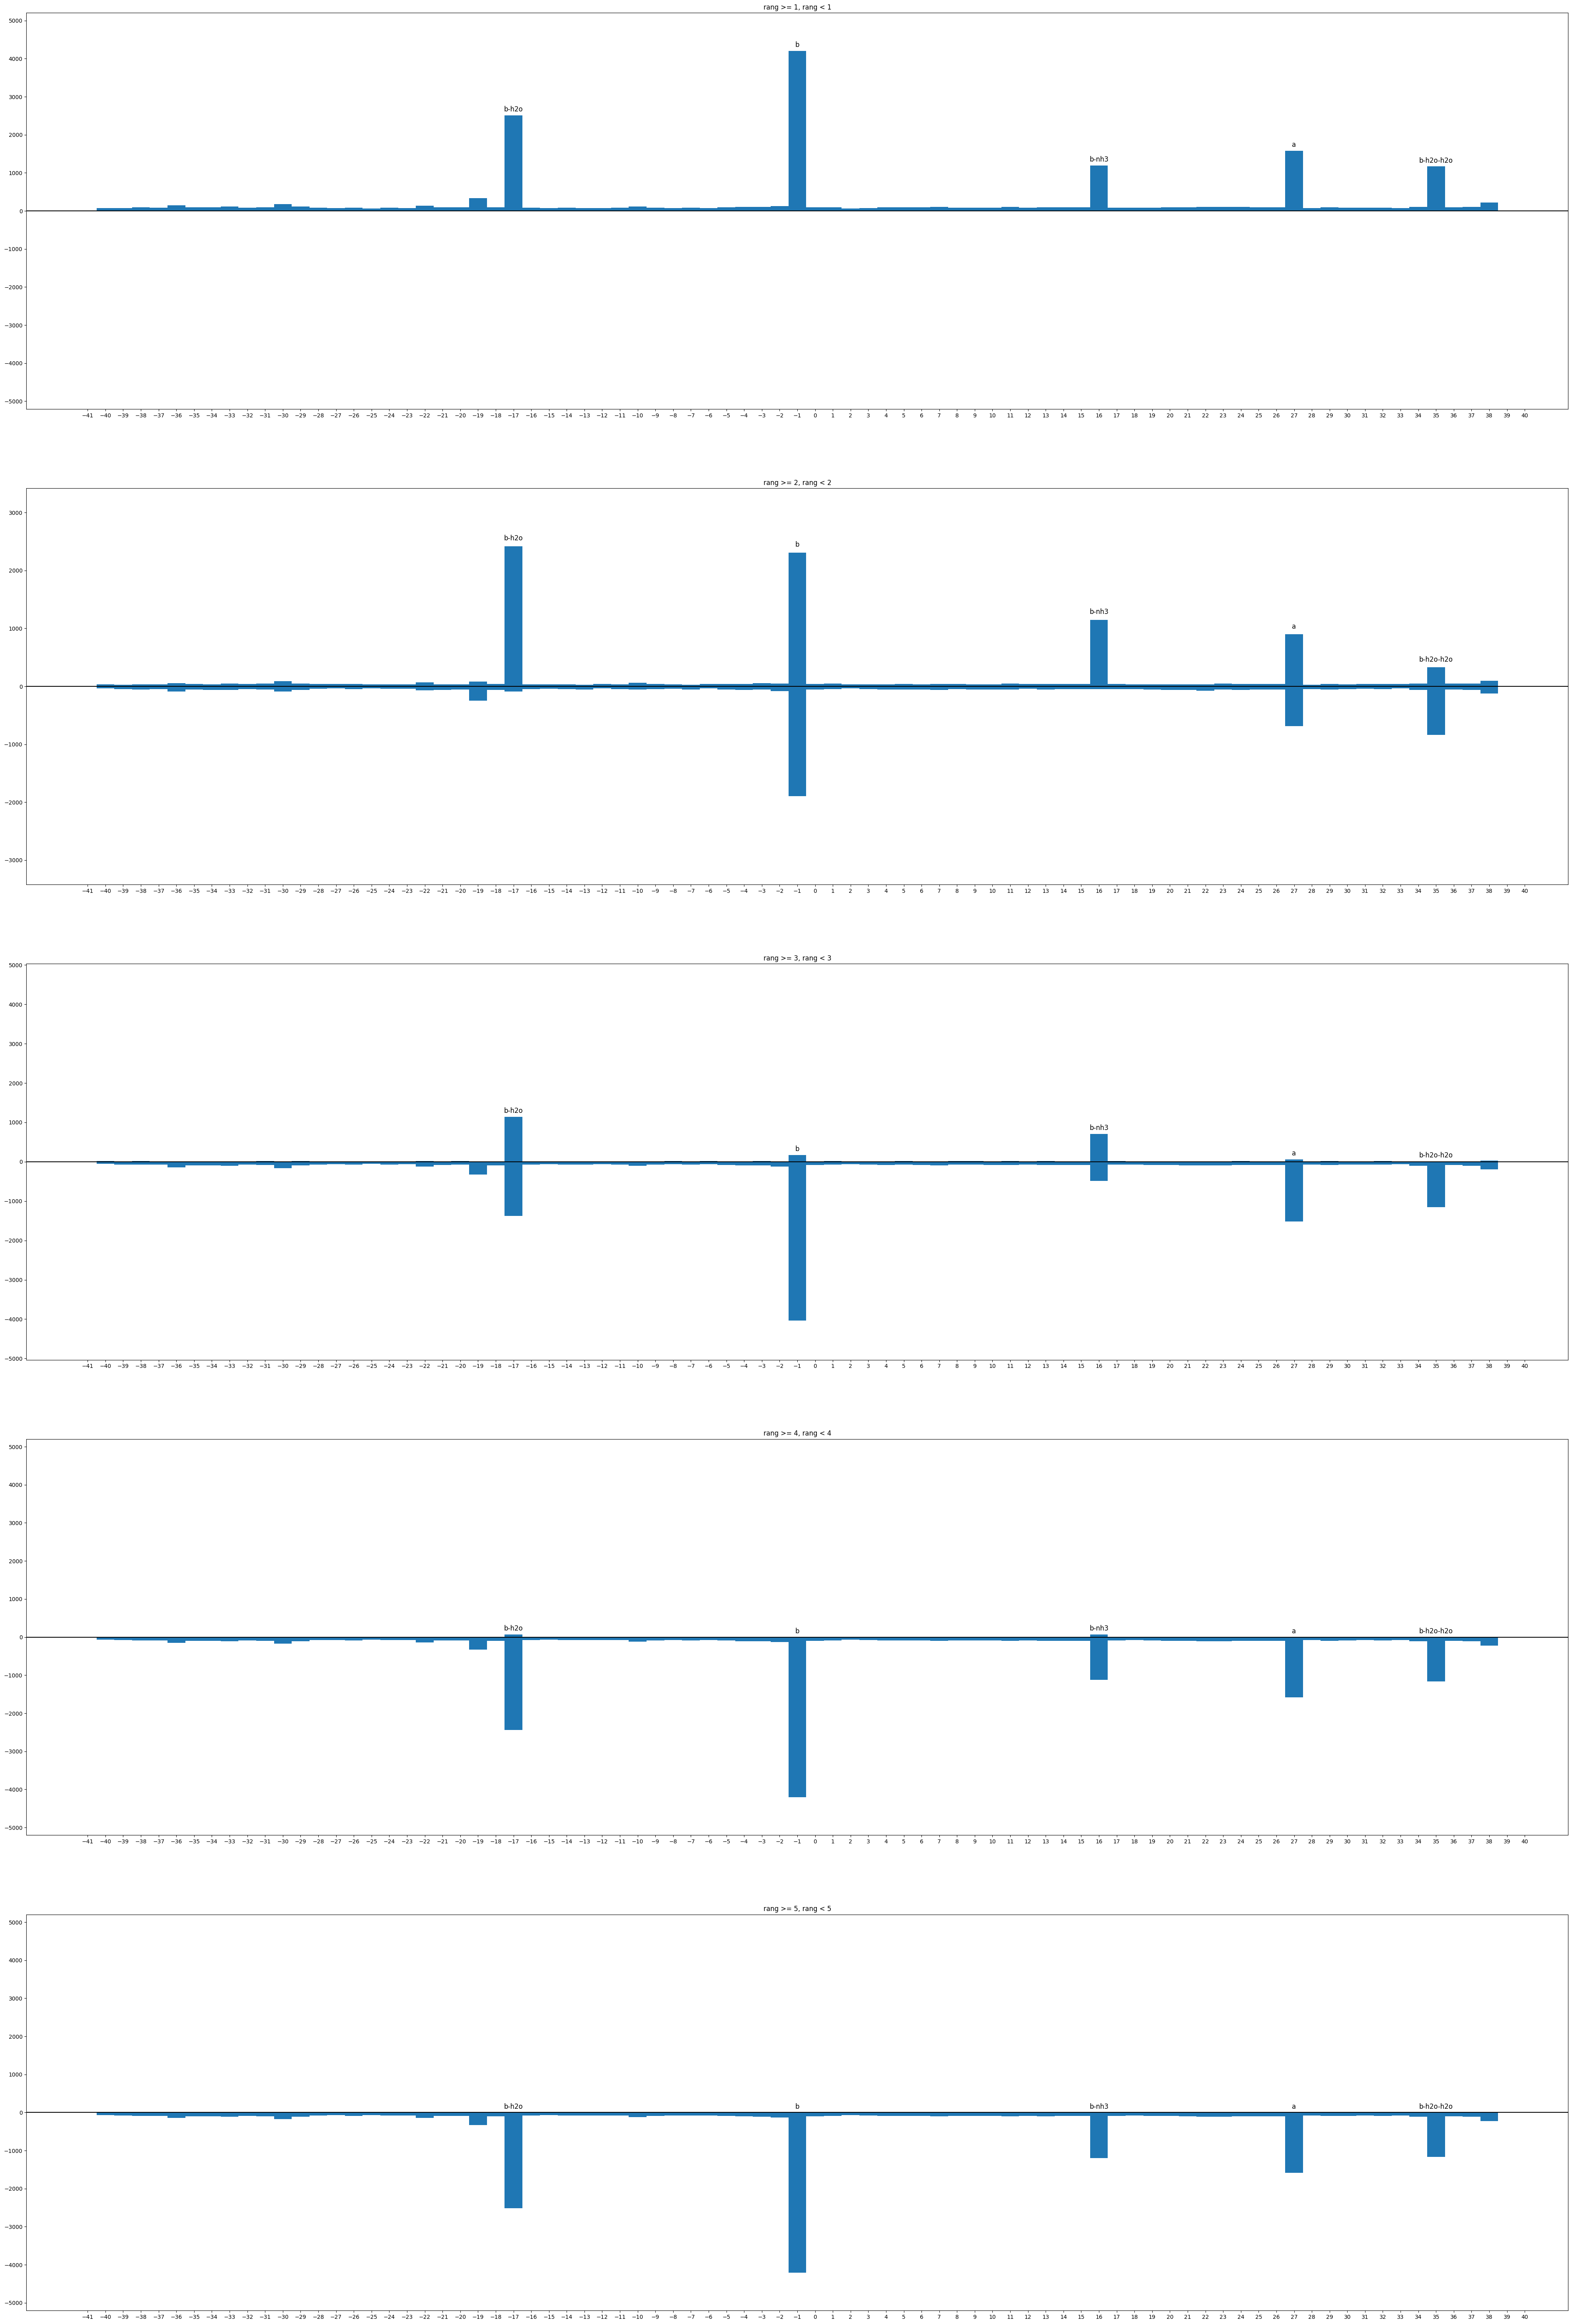

In [379]:
trening_skup.funkcija_ucestalosti_pomeraja_po_grupama_intenziteta(naelektrisanje=1, prefiks=True)

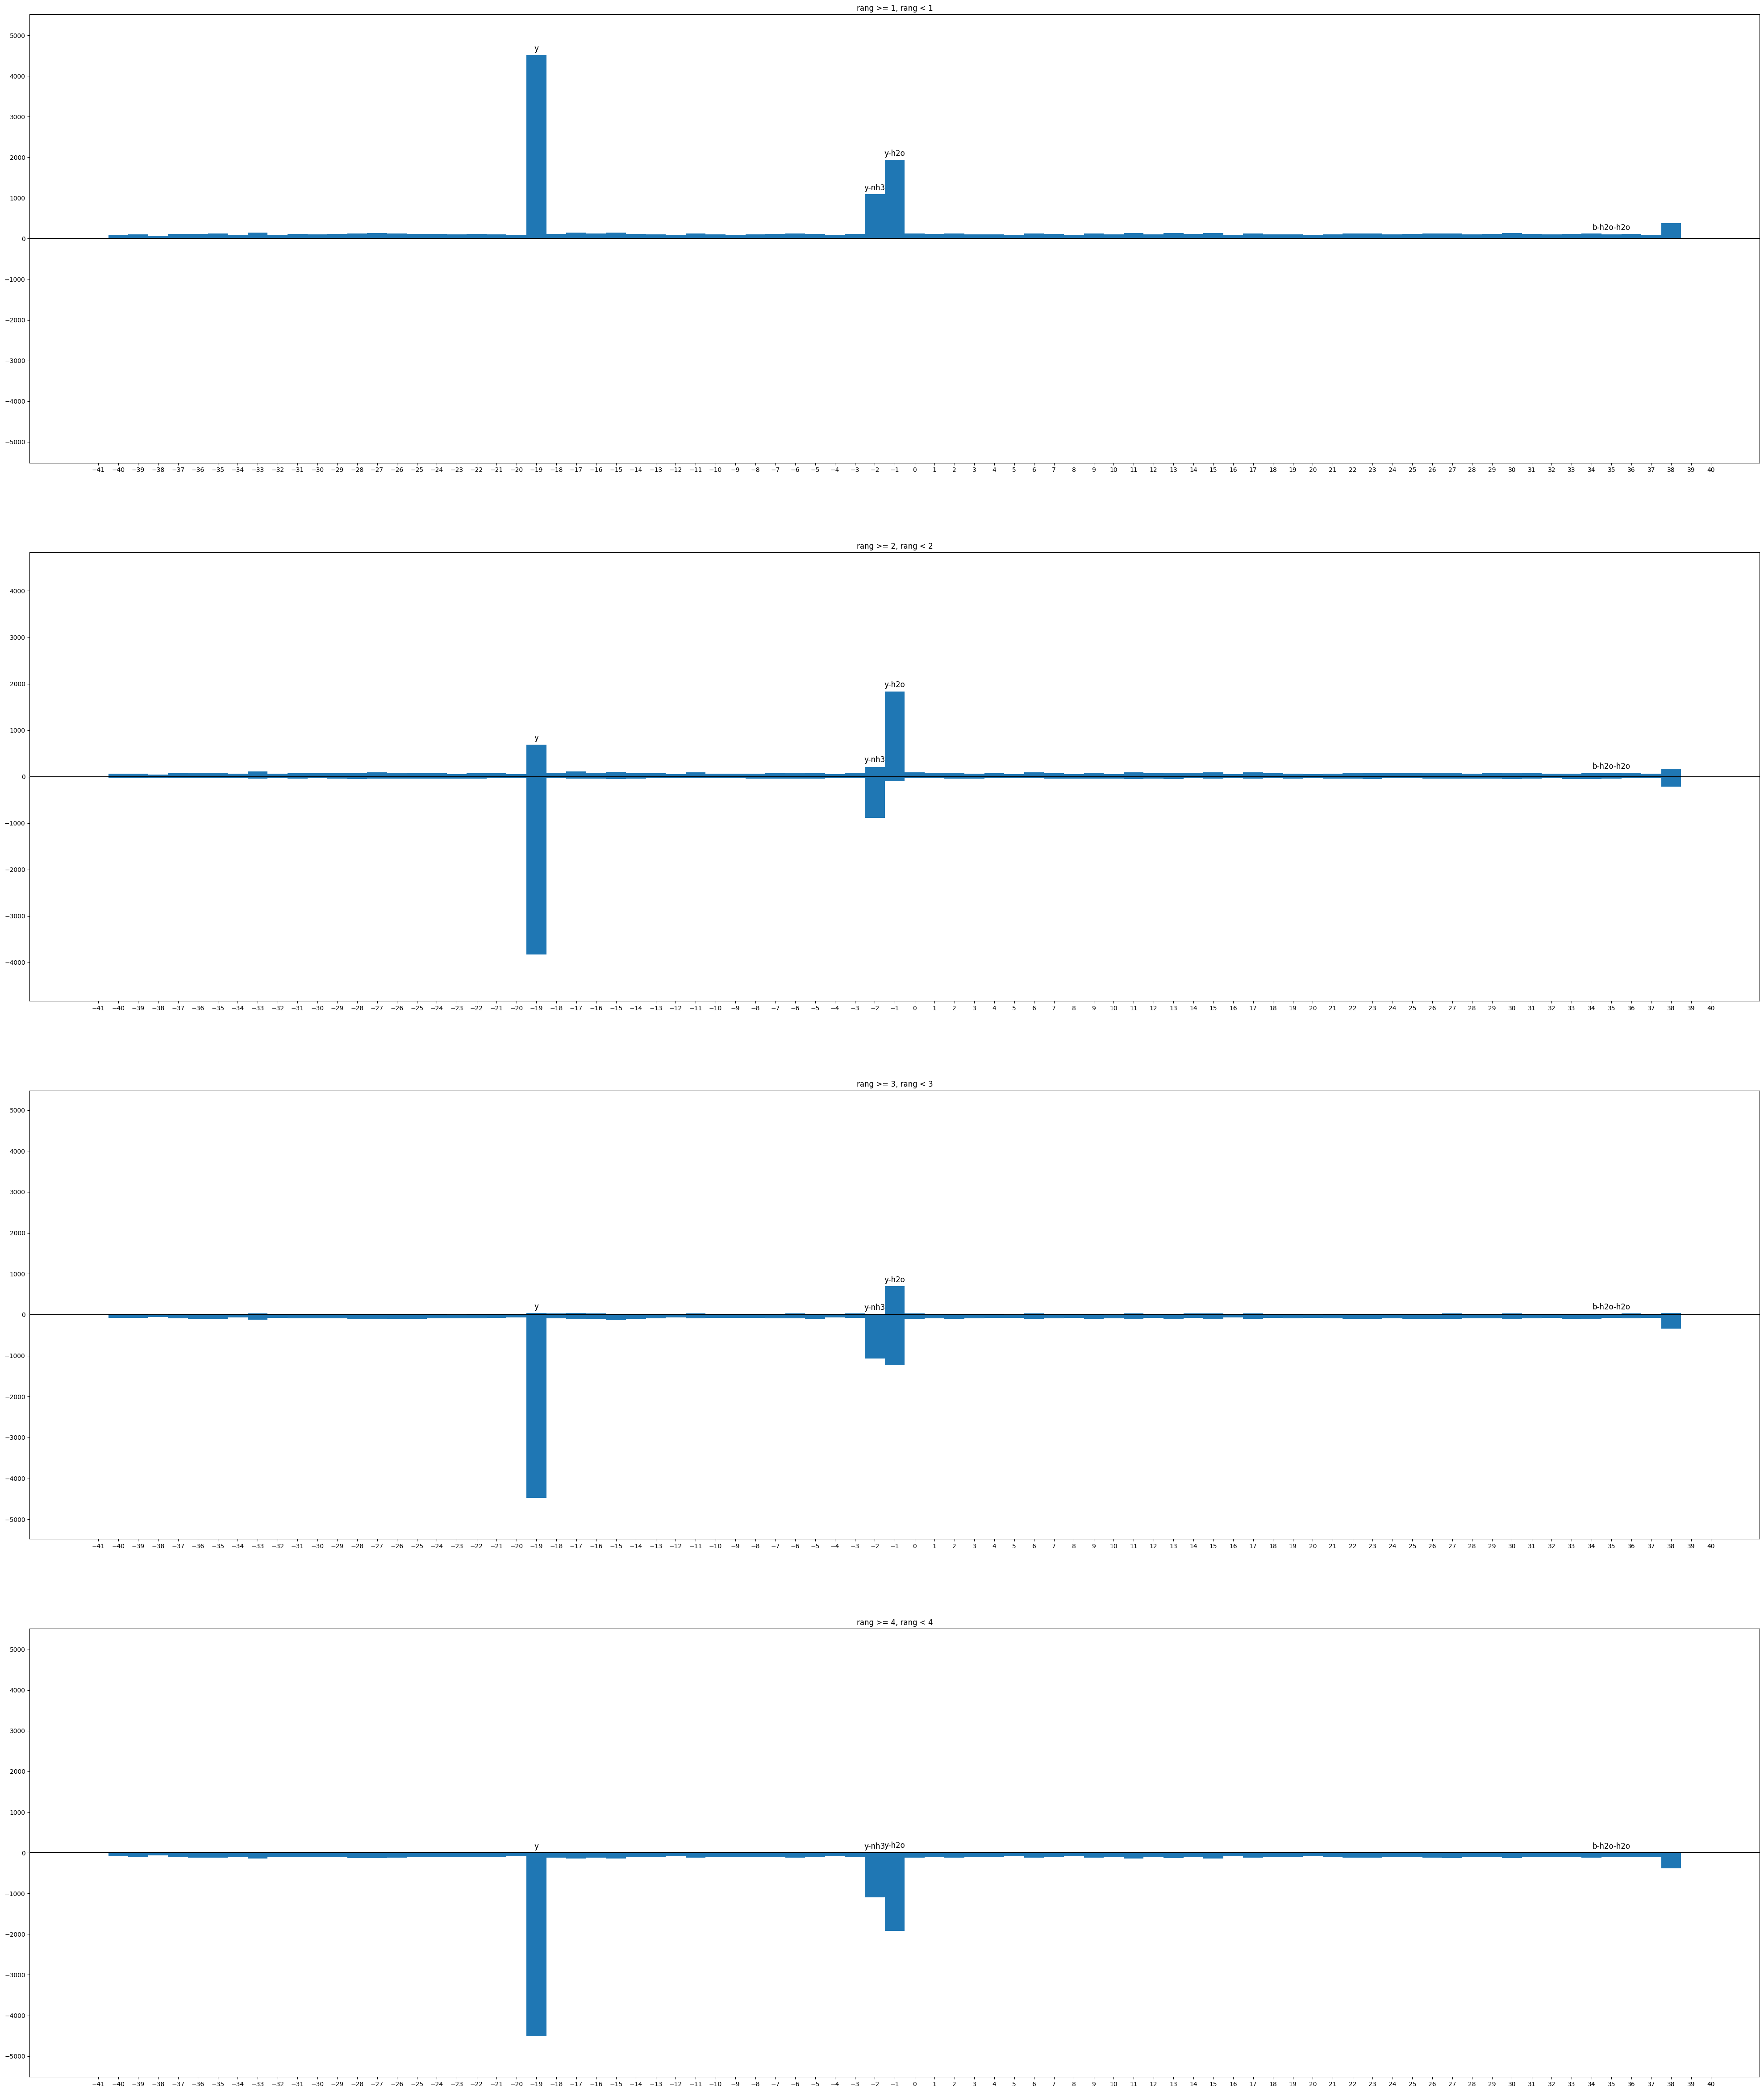

In [352]:
trening_skup.funkcija_ucestalosti_pomeraja_po_grupama_intenziteta(naelektrisanje=1, prefiks=False)

In [99]:
delilac_mase_za_procenu_duzine = []
for i in range(1000):
    peptid = Peptid(generisi_slucajan_peptid())
    delilac_mase_za_procenu_duzine.append(peptid.masa/len(peptid))

print(f"{np.mean(delilac_mase_za_procenu_duzine):.2f}, {np.median(delilac_mase_za_procenu_duzine):.2f}, {np.min(delilac_mase_za_procenu_duzine):.2f}, {np.max(delilac_mase_za_procenu_duzine):.2f}")

118.33, 118.49, 86.38, 145.64


In [100]:
def podeli_listu(lista, broj_elemenata_po_listi):
    broj_delova = len(lista) // broj_elemenata_po_listi
    rezultat = []
    
    for i in range(0,broj_delova+1):
        rezultat.append(lista[i*(broj_elemenata_po_listi):broj_elemenata_po_listi*(i+1)])
    
    return rezultat

In [295]:
broj_pozicija = {jon:0 for jon in celobrojni_pomeraj_fragmentnih_jona.keys()} 
broj_odgovarajucih = {jon:0 for jon in celobrojni_pomeraj_fragmentnih_jona.keys()} 

for i in range(0,len(trening_skup.peptidi_i_spektri)):    
    peptid = trening_skup.peptidi_i_spektri[i][0].peptid
    spektar = trening_skup.peptidi_i_spektri[i][1].mase_intenziteti
    
    duzina_peptida = len(peptid)
    
    for j in range(duzina_peptida):
        prefiksna_masa = Peptid(peptid[0:j]).masa
        sufiksna_masa = Peptid(peptid[j:]).masa 
        
        for jon, pomeraj in celobrojni_pomeraj_fragmentnih_jona.items():
            
            # sufiksni peptidi
            if np.any([jon.startswith(oznaka) for oznaka in ["x","y","z"]]):
                broj_pozicija[jon] += (1 if ((sufiksna_masa + pomeraj >= 91) and (sufiksna_masa + pomeraj <= 2000)) else 0)
                broj_odgovarajucih[jon] += len(spektar[(spektar["m_z"] >= sufiksna_masa + pomeraj - 0.5) & (spektar["m_z"] <= sufiksna_masa + pomeraj + 0.5)])

            # prefiksni peptidi
            elif np.any(jon.startswith(oznaka) for oznaka in ["a","b","c"]):
                broj_pozicija[jon] += (1 if ((prefiksna_masa + pomeraj >= 91) and (prefiksna_masa + pomeraj <= 2000)) else 0)
                broj_odgovarajucih[jon] += len(spektar[(spektar["m_z"] >= prefiksna_masa + pomeraj - 0.5) & (spektar["m_z"] <= prefiksna_masa + pomeraj + 0.5)])


In [296]:
for jon in celobrojni_pomeraj_fragmentnih_jona.keys():
    print(f"Broj pozicija: {broj_pozicija[jon]}; Broj odgovarajucih pikova: {broj_odgovarajucih[jon]}; Verovatnoca = {round(broj_odgovarajucih[jon]/broj_pozicija[jon],5)}")

Broj pozicija: 6489; Broj odgovarajucih pikova: 4561; Verovatnoca = 0.70288
Broj pozicija: 6231; Broj odgovarajucih pikova: 4154; Verovatnoca = 0.66667
Broj pozicija: 6219; Broj odgovarajucih pikova: 2535; Verovatnoca = 0.40762
Broj pozicija: 6489; Broj odgovarajucih pikova: 1955; Verovatnoca = 0.30128
Broj pozicija: 6073; Broj odgovarajucih pikova: 1522; Verovatnoca = 0.25062
Broj pozicija: 6159; Broj odgovarajucih pikova: 1165; Verovatnoca = 0.18915
Broj pozicija: 6488; Broj odgovarajucih pikova: 1094; Verovatnoca = 0.16862
Broj pozicija: 6092; Broj odgovarajucih pikova: 1133; Verovatnoca = 0.18598


In [297]:
eksperimentalna_verovatnoca = {
    x: round(broj_odgovarajucih[x]/broj_pozicija[x], 5) for x in celobrojni_pomeraj_fragmentnih_jona.keys()
}

In [ ]:
def verovatnoce_tipova_jona_po_rangovima(broj_rangova):
    pass

In [353]:
class MaseniSpektar:    
    def __init__(self, spektar, roditeljska_masa):
        self.m_z = sorted(list(spektar["m_z"].astype('int64')))
        self.intenziteti = list(spektar["intenzitet"])   
        self.roditeljska_masa = roditeljska_masa
        self.spektralni_vektor = self._spektralni_vektor()
        self.mase_intenziteti = spektar.sort_values(by="intenzitet", ascending=False).reset_index(drop=True)

        self.dodeli_rangove_spektru()
        
    def __str__(self):
        return None 
    
    def dodeli_rangove_spektru(self):
        K = self.roditeljska_masa // 100 # velicina bina 
        # K = trening_skup.peptidi_i_spektri[i][0].masa // 100
        broj_rangova = len(self.mase_intenziteti) // K + 1 
        
        for j in range(0, len(self.mase_intenziteti)//K + 1):
            self.mase_intenziteti.loc[j*K:(j+1)*K, "rang"] = j + 1
            
    # TODO: kreirati amplitude
    # rasporediti intenzitete u rangove DONE
    # kreirati verovatnoce po rangovima (off) TODO NEXT
    # skoring funkcija: O
    
    # ZASTO MORAJU BITI integeri, zasto je to pretpostavka, sta ona olaksava?
        # skoring se izvodi kao dot-product :) 
    # Vertices of the graph are integers representing potential masses of partial peptides. 
    def _spektralni_graf(self):
        pass
    
    def _spektralni_vektor(self):
        vektor = [0] * (self.m_z[-1] + 1)
        
        for i in range(len(self.m_z)):
            vektor[self.m_z[i]] = self.intenziteti[i]

        return vektor

In [ ]:
def skor(peptid, spektar):
    pass

In [390]:
def dodeli_rangove_spektru(spektar, roditeljska_masa):
    
    spektar = spektar.sort_values(by="intenzitet", ascending=False).reset_index(drop=True)

    K = roditeljska_masa // 100 # velicina bina 
    broj_rangova = len(spektar) // K + 1 

    for j in range(0, len(spektar)//K + 1):
        spektar.loc[j*K:(j+1)*K, "rang"] = j + 1
        
    spektar.rang = spektar.rang.astype('int')
    return spektar

In [394]:
broj_pozicija = {jon:{} for jon in celobrojni_pomeraj_fragmentnih_jona.keys()} 
broj_odgovarajucih = {jon:{} for jon in celobrojni_pomeraj_fragmentnih_jona.keys()} 

for i in range(0,len(trening_skup.peptidi_i_spektri)):    
    peptid = trening_skup.peptidi_i_spektri[i][0] #.peptid
    spektar = trening_skup.peptidi_i_spektri[i][1].mase_intenziteti
    
    spektar = dodeli_rangove_spektru(spektar, peptid.masa)
    peptid = peptid.peptid
    duzina_peptida = len(peptid)
    
    for j in range(duzina_peptida):
        prefiksna_masa = Peptid(peptid[0:j]).masa
        sufiksna_masa = Peptid(peptid[j:]).masa 
        
        for jon, pomeraj in celobrojni_pomeraj_fragmentnih_jona.items():
            for rang in range(1, max(spektar.rang)+1):
                
                if rang not in broj_pozicija[jon]:
                    broj_pozicija[jon][rang] = 0
                    
                if rang not in broj_odgovarajucih[jon]:
                    broj_odgovarajucih[jon][rang] = 0
                
                # sufiksni peptidi
                if np.any([jon.startswith(oznaka) for oznaka in ["x","y","z"]]):
                    broj_pozicija[jon][rang] += (1 if ((sufiksna_masa + pomeraj >= 91) and (sufiksna_masa + pomeraj <= 2000)) else 0)
                    broj_odgovarajucih[jon][rang] += len(spektar[
                        (spektar["m_z"] >= sufiksna_masa + pomeraj - 0.5) & 
                        (spektar["m_z"] <= sufiksna_masa + pomeraj + 0.5) &
                        (spektar["rang"] == rang)
                    ])

                # prefiksni peptidi
                elif np.any(jon.startswith(oznaka) for oznaka in ["a","b","c"]):
                    broj_pozicija[jon][rang] += (1 if ((prefiksna_masa + pomeraj >= 91) and (prefiksna_masa + pomeraj <= 2000)) else 0)
                    broj_odgovarajucih[jon][rang] += len(spektar[
                        (spektar["m_z"] >= prefiksna_masa + pomeraj - 0.5) & 
                        (spektar["m_z"] <= prefiksna_masa + pomeraj + 0.5) &
                        (spektar["rang"] == rang)
                    ])


C:\Users\ajakovljevic\AppData\Local\Temp\ipykernel_8480\390289043.py:9: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  spektar.loc[j*K:(j+1)*K, "rang"] = j + 1


In [404]:
broj_odgovarajucih

{'y': {1: 3867, 2: 644, 3: 29, 4: 1, 5: 0},
 'b': {1: 1891, 2: 2102, 3: 132, 4: 1, 5: 0},
 'b-h2o': {1: 93, 2: 1282, 3: 1067, 4: 69, 5: 1},
 'y-h2o': {1: 105, 2: 1197, 3: 605, 4: 14, 5: 0},
 'a': {1: 685, 2: 836, 3: 60, 4: 0, 5: 0},
 'b-nh3': {1: 46, 2: 439, 3: 640, 4: 69, 5: 0},
 'y-nh3': {1: 857, 2: 179, 3: 21, 4: 0, 5: 0},
 'b-h2o-h2o': {1: 840, 2: 313, 3: 12, 4: 0, 5: 0}}

In [405]:
broj_pozicija

{'y': {1: 6471, 2: 6455, 3: 4599, 4: 715, 5: 8},
 'b': {1: 6218, 2: 6204, 3: 4366, 4: 663, 5: 7},
 'b-h2o': {1: 6212, 2: 6198, 3: 4361, 4: 664, 5: 7},
 'y-h2o': {1: 6471, 2: 6455, 3: 4592, 4: 709, 5: 8},
 'a': {1: 6065, 2: 6051, 3: 4242, 4: 634, 5: 6},
 'b-nh3': {1: 6141, 2: 6127, 3: 4306, 4: 645, 5: 6},
 'y-nh3': {1: 6469, 2: 6453, 3: 4592, 4: 709, 5: 8},
 'b-h2o-h2o': {1: 6079, 2: 6065, 3: 4247, 4: 634, 5: 6}}

In [407]:
eksperimentalna_verovatnoca_jona_po_rangovima = {
    jon: {
        rang: round(broj_odgovarajucih[jon][rang]/broj_pozicija[jon][rang], 5) for rang in po_rangovima
    } for jon, po_rangovima in broj_odgovarajucih.items()
}

In [408]:
eksperimentalna_verovatnoca_jona_po_rangovima

{'y': {1: 0.59759, 2: 0.09977, 3: 0.00631, 4: 0.0014, 5: 0.0},
 'b': {1: 0.30412, 2: 0.33881, 3: 0.03023, 4: 0.00151, 5: 0.0},
 'b-h2o': {1: 0.01497, 2: 0.20684, 3: 0.24467, 4: 0.10392, 5: 0.14286},
 'y-h2o': {1: 0.01623, 2: 0.18544, 3: 0.13175, 4: 0.01975, 5: 0.0},
 'a': {1: 0.11294, 2: 0.13816, 3: 0.01414, 4: 0.0, 5: 0.0},
 'b-nh3': {1: 0.00749, 2: 0.07165, 3: 0.14863, 4: 0.10698, 5: 0.0},
 'y-nh3': {1: 0.13248, 2: 0.02774, 3: 0.00457, 4: 0.0, 5: 0.0},
 'b-h2o-h2o': {1: 0.13818, 2: 0.05161, 3: 0.00283, 4: 0.0, 5: 0.0}}

# Treba li da izracunam verovatnocu suma ili da je fiksiram na neku vrednost (npr 0.1) ? 

# Kako izgleda stварни масени спектар ?
Prilicno slicno :) 

In [606]:
class MaseniSpektar:
    
    def __init__(self, mase_intenziteti, roditeljska_masa): 
        self.mase_intenziteti = mase_intenziteti
        self.roditeljska_masa = roditeljska_masa
        
        for atribut in ["m_z", "intenziteti", "spektralni_vektor", "graf"]:
            setattr(self, atribut, getattr(self, "_" + atribut)())
        
    def __str__(self):
        return None 
    
    def __repr__(self):
        return str(self.mase_intenziteti)
    
    def _spektralni_vektor(self):
        vektor = [0] * int(self.m_z[-1] + 1)

        for i in range(len(self.m_z)):
            vektor[self.m_z[i]] = self.intenziteti[i]

        return vektor
    
    def _m_z(self):
        return [round(x) for x in list(self.mase_intenziteti["m_z"])]
    
    def _intenziteti(self):
        return list(self.mase_intenziteti["intenzitet"])
    
    def grupe_intenziteta(self):
        grupe = dict({})

        sortirani_spektar = self.mase_intenziteti.sort_values(by="intenzitet", ascending=False)

        K = int(max(self.m_z)/100)
        for i in range(0, len(sortirani_spektar)//K):
            grupe[i] = sortirani_spektar.iloc[i*K:(i+1)*K]
        
        return grupe
        
    """
    def _prefiksi_spektra(self):
        return pd.DataFrame([(float(x[0]), float(x[1]), x[2]) for x in ceo_spektar if any(prefiks in x[-1] for prefiks in ["a","b","c"])], columns=["m_z","intenzitet", "anotacija"])

    def _sufiksi_spektra(self):
        return pd.DataFrame([(float(x[0]), float(x[1]), x[2]) for x in ceo_spektar if any(sufiks in x[-1] for sufiks in ["x","y","z"])], columns=["m_z","intenzitet", "anotacija"]) 
    """
    
    def _graf(self):
        # na osnovu spektralnog vektora
        return None
    
    def iscrtaj_ulazni_spektar(self): 
        fig, ax = plt.subplots(figsize=(50, 20))
        # podesiti width i linewidth
        ax.bar(self.mase_intenziteti["m_z"], height=self.mase_intenziteti["intenzitet"], width=0.8,  linewidth=1)

        oznake_pikova = np.where(self.mase_intenziteti["intenzitet"] >= 50, self.mase_intenziteti["m_z"], 0)

        #for indeks, oznaka in enumerate(list(oznake_pikova)):
        #    if oznaka != 0:
        #        ax.annotate(oznaka, (self.mase_intenziteti.loc[indeks, "m_z"], self.mase_intenziteti.loc[indeks, "intenzitet"]))

        plt.show()

In [265]:
class TreningSkup:

    def __init__(self, naziv_datoteke, naelektrisanje=None):
        self.peptidi_i_spektri = self.procitaj_peptide_i_spektre(naziv_datoteke, naelektrisanje)
        
    def procitaj_peptide_i_spektre(self, naziv_datoteke, naelektrisanje=None):
        
        with open(naziv_datoteke, "r") as datoteka:
            podaci = datoteka.read()
        
        if naelektrisanje is None:
            regex = r"Name: (\w+)(?:.*)\nMW: ((?:(?:[0-9]*[.])?[0-9]+))\nComment:(?:.*)\nNum peaks: (?:\d+)\n((?:[0-9]*[.]?[0-9]+(?:\s+)[0-9]*[.]?[0-9]+(?:\s+)(?:.*)\n?)+)"
        else:
            regex = r"Name: (\w+)(?:.*)\nMW: ((?:(?:[0-9]*[.])?[0-9]+))\nComment:(?:.*)Charge={" + str(naelektrisanje) + r"}(?:.*)\nNum peaks: (?:\d+)\n((?:[0-9]*[.]?[0-9]+(?:\s+)[0-9]*[.]?[0-9]+(?:\s+)(?:.*)\n?)+)"

        # regex = r"Name: (\w+)(?:.*)\nComment:(?:.*)\nNum peaks: (?:\d+)\n((?:[0-9]*[.]?[0-9]+(?:\s+)[0-9]*[.]?[0-9]+(?:\s+)(?:.*)\n?)+)"
        sablon = re.compile(regex)
        
        peptidi_i_spektri = []

        for pronadjeno in re.findall(sablon, podaci):
            peptid = Peptid(pronadjeno[0])
            roditeljska_masa = float(pronadjeno[1])

            ceo_spektar = [x.split() for x in pronadjeno[2].strip().split("\n")]
            spektar = pd.DataFrame([(float(x[0]), float(x[1]), x[2]) for x in ceo_spektar if "?" not in x[2]], columns=["m_z","intenzitet","anotacija"])
            peptidi_i_spektri.append((peptid, MaseniSpektar(spektar, roditeljska_masa)))

        return peptidi_i_spektri
    
    @classmethod
    def pomocna_funkcija_ucestalosti(cls, peptidne_mase, spektralne_mase, naelektrisanje):
        pomeraji = []
        
        for Pi in peptidne_mase:
            for sj in spektralne_mase:
                pomeraji.append(Pi - naelektrisanje * sj)
                
        return pomeraji
    
    def funkcija_ucestalosti_pomeraja(self, naelektrisanja, prefiks):
        fig, axs = plt.subplots(len(naelektrisanja), 1, figsize=(50, len(naelektrisanja)*10))
        
        axs = axs if len(naelektrisanja) != 1 else [axs]
        
        for i, naelektrisanje in enumerate(naelektrisanja):
            pomeraji = []

            for (peptid, spektar) in self.peptidi_i_spektri:
                peptidne_mase = peptid.vektor_prefiksnih_masa if prefiks else peptid.vektor_sufiksnih_masa
                pomeraji += TreningSkup.pomocna_funkcija_ucestalosti(peptidne_mase, spektar.m_z, naelektrisanje)

                #for Pi in peptidne_mase:
                #    for sj in spektar.m_z:
                #        pomeraji.append(Pi - naelektrisanje * sj)

            axs[i].hist(pomeraji, bins=np.arange(-50, 50, 0.01), density=True, stacked=True)
            axs[i].set_xticks(np.arange(-50, 50, 1))
            axs[i].set_title(f"naelektrisanje={naelektrisanje}; {'prefiksi' if prefiks else 'sufiksi'}")
            
        plt.show()        
    
    def funkcija_ucestalosti_pomeraja_po_grupama_intenziteta(self, naelektrisanje, prefiks, broj_rangova):        
        pomeraji = dict({})
        
        for i in range(len(self.peptidi_i_spektri)):
            grupe = dict({})
            
            peptid, spektar = self.peptidi_i_spektri[i]
            sortirani_spektar = spektar.mase_intenziteti.sort_values(by="intenzitet", ascending=False)
            
            peptidne_mase = peptid.vektor_prefiksnih_masa if prefiks else peptid.vektor_sufiksnih_masa
            
            K = int(peptid.masa/100)
            for i in range(0, len(sortirani_spektar)//K):
                grupe[i] = sortirani_spektar.iloc[i*K:(i+1)*K]

            for i in range(0, broj_rangova+1):
                if len(grupe.items()) > i:
                    pomeraji[i] = pomeraji.get(i, []) + TreningSkup.pomocna_funkcija_ucestalosti(peptidne_mase, grupe[i].m_z, naelektrisanje)
                    
        fig, axs = plt.subplots(broj_rangova, 1 ,figsize=(50, 15*broj_rangova))

        for k in range(0, broj_rangova):
            pomeraji_manji_od_k = []
            pomeraji_veci_jednaki_od_k = []

            for i in range(0, k):
                pomeraji_manji_od_k += pomeraji[i]

            for i in range(k, broj_rangova):
                pomeraji_veci_jednaki_od_k += pomeraji[i]

            histogram_manjih = np.histogram(pomeraji_manji_od_k, bins=np.arange(-50, 50, 0.01))
            histogram_vecih = np.histogram(pomeraji_veci_jednaki_od_k, bins=np.arange(-50, 50, 0.01))

            x = np.concatenate((0.5*(histogram_manjih[1][1:] + histogram_manjih[1][:-1]), 0.5*(histogram_vecih[1][1:] + histogram_vecih[1][:-1])))
            y = np.concatenate((histogram_manjih[0] * -1, histogram_vecih[0]))

            axs[k].bar(x=x, height=y, width=0.01)
            axs[k].set_xticks(np.arange(-50, 50, 1))
            #axs[k].set_ylim(-100, 100)
            axs[k].set_title(f"rang= {k+1}")
            
        plt.show()

In [266]:
trening_skup = TreningSkup("podaci/chicken.txt")
gc.collect()

TypeError: __init__() takes 2 positional arguments but 3 were given

In [610]:
def analiza_stvarnog_spektra_radi_simulacije():
    naziv_datoteke="podaci/chicken.txt"
    naelektrisanje=None

    with open(naziv_datoteke, "r") as datoteka:
        podaci = datoteka.read()

    if naelektrisanje is None:
        regex = r"Name: (\w+)(?:.*)\nMW: ((?:(?:[0-9]*[.])?[0-9]+))\nComment:(?:.*)\nNum peaks: (?:\d+)\n((?:[0-9]*[.]?[0-9]+(?:\s+)[0-9]*[.]?[0-9]+(?:\s+)(?:.*)\n?)+)"
    else:
        regex = r"Name: (\w+)(?:.*)\nMW: ((?:(?:[0-9]*[.])?[0-9]+))\nComment:(?:.*)Charge={" + str(naelektrisanje) + r"}(?:.*)\nNum peaks: (?:\d+)\n((?:[0-9]*[.]?[0-9]+(?:\s+)[0-9]*[.]?[0-9]+(?:\s+)(?:.*)\n?)+)"

    sablon = re.compile(regex)
    peptidi_i_spektri = []

    for pronadjeno in re.findall(sablon, podaci):
        peptid = Peptid(pronadjeno[0])
        roditeljska_masa = float(pronadjeno[1])

        ceo_spektar = [x.split() for x in pronadjeno[2].strip().split("\n")]
        spektar = pd.DataFrame([(float(x[0]), float(x[1]), x[2]) for x in ceo_spektar if "?" not in x[2]], columns=["m_z","intenzitet","anotacija"])
        peptidi_i_spektri.append((peptid, MaseniSpektar(spektar, roditeljska_masa)))
    
    return peptidi_i_spektri
    broj_spektara = len([x[0] for x in peptidi_i_spektri])
    broj_razlicitih_peptida = len(set([x[0] for x in peptidi_i_spektri]))
    duzine_peptida = list(set([len(x[0]) for x in peptidi_i_spektri]))

    broj_pikova_po_spektru = [len(x[1].m_z) for x in peptidi_i_spektri]
    print(f"broj_pikova_po_spektru: {min(broj_pikova_po_spektru), np.mean(broj_pikova_po_spektru), max(broj_pikova_po_spektru), }")
    
    m_z_ovi = []
    for m_z in [x[1].m_z for x in peptidi_i_spektri]:
        m_z_ovi.extend(m_z)
    print(f"m_z: {min(m_z_ovi), max(m_z_ovi)}")

    intenziteti = []
    for lst in [x[1].intenziteti for x in peptidi_i_spektri]:
        intenziteti.extend(lst)

    display(np.percentile(intenziteti, 10), np.percentile(intenziteti, 25), np.percentile(intenziteti, 50),  np.percentile(intenziteti, 75),  np.percentile(intenziteti, 90))
    display(min(duzine_peptida), max(duzine_peptida))
    print(f"broj spektara: {broj_spektara}, broj razlicitih peptida: {broj_razlicitih_peptida}")

    broj_razlicitih_spektara_po_peptidu = {}
    for peptid, spektar in peptidi_i_spektri:
        if peptid in broj_razlicitih_spektara_po_peptidu:
            broj_razlicitih_spektara_po_peptidu[peptid] += 1
        else:
            broj_razlicitih_spektara_po_peptidu[peptid] = 1

    lista_vrednosti = list(broj_razlicitih_spektara_po_peptidu.values())
    print(f"srednja vrednost broja razlicitih spektara po peptidu: {np.mean(lista_vrednosti)}, medijana broja razlicitih spektara po peptidu: {np.median(lista_vrednosti)}, maksimalna vrednost broja razlicitih spektara po peptidu: {np.max(lista_vrednosti)}")

    minimalan_intenzitet = min([min(spektar.intenziteti) for _, spektar in peptidi_i_spektri])
    maksimalan_intenzitet = max([max(spektar.intenziteti) for _, spektar in peptidi_i_spektri])
    print(f"minimalan intenzitet spektra: {minimalan_intenzitet}, maksimalan intenzitet spektra: {maksimalan_intenzitet}")

In [612]:
peptidi_i_spektri = analiza_stvarnog_spektra_radi_simulacije()

In [623]:
peptidi_i_spektri[0][1]

       m_z  intenzitet          anotacija
0    364.2       258.0     "Int/YEA/0.10"
1    377.2       231.0    "Int/AAAY/0.00"
2    414.3       215.0      "y4-NH3/0.07"
3    419.2       304.0    "Int/AAYI/0.00"
4    420.2       279.0         "a5/-0.01"
..     ...         ...                ...
59  1141.5      1333.0        "y10/-0.09"
60  1247.6       268.0     "p-2H2O/-0.02"
61  1248.5       787.0  "p-H2O-NH3/-0.11"
62  1265.4      2351.0      "p-H2O/-0.24"
63  1266.5      5113.0      "p-NH3/-0.13"

[64 rows x 3 columns]

In [625]:
[ x for x in [(len(peptidi_i_spektri[i][1].m_z), i) for i in range (len(peptidi_i_spektri))] if x[0] > 150]

[(155, 54),
 (152, 248),
 (155, 313),
 (155, 480),
 (152, 664),
 (152, 665),
 (167, 807),
 (159, 874),
 (153, 1159),
 (157, 1192),
 (152, 1249),
 (161, 1251),
 (151, 1259),
 (178, 1301),
 (175, 1359),
 (159, 1398),
 (160, 1441),
 (156, 1494),
 (153, 1529),
 (152, 1621),
 (152, 2130),
 (164, 2134),
 (156, 2143),
 (167, 2288),
 (161, 2438),
 (156, 2535),
 (179, 2775),
 (160, 2776),
 (168, 2859),
 (157, 2877),
 (153, 2937),
 (151, 2991),
 (151, 3082)]

In [636]:
set([x[1] for x in peptidi_i_spektri[1359][1].mase_intenziteti.anotacija])

{'b', 'p', 'y'}

In [536]:
trening_skup.funkcija_ucestalosti_pomeraja_po_grupama_intenziteta(naelektrisanje=1, prefiks=False, broj_rangova=5)
gc.collect()

KeyboardInterrupt: 

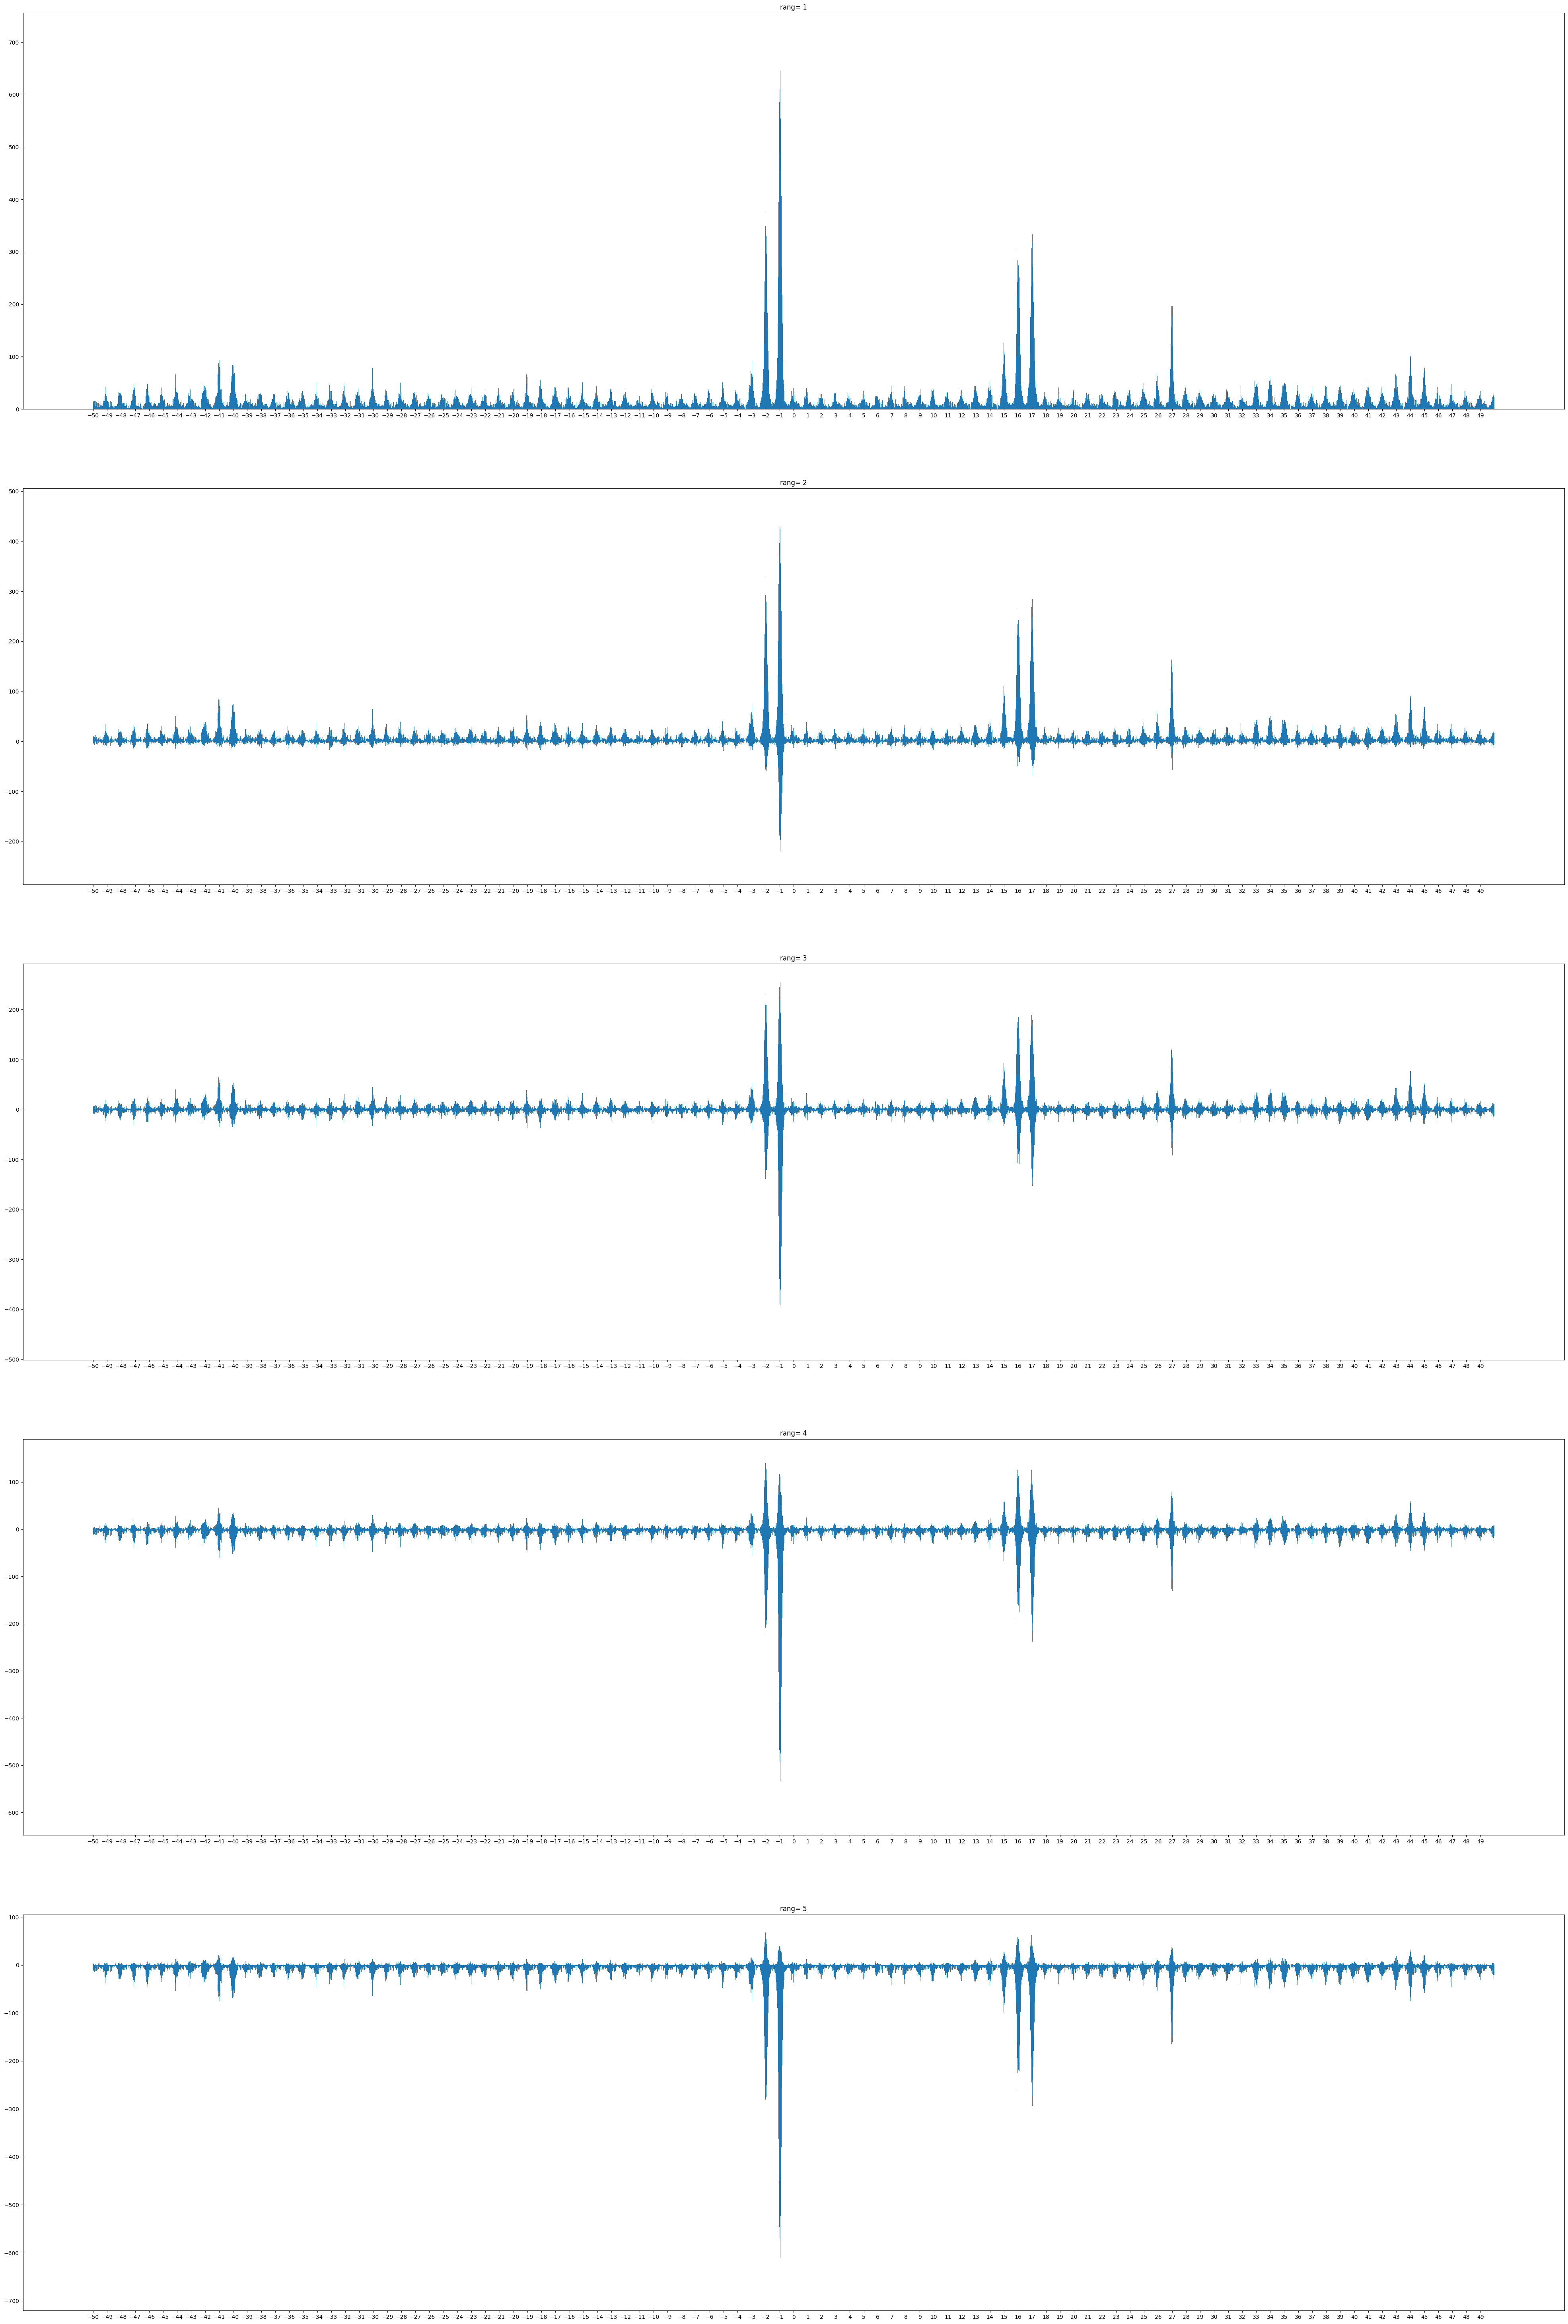

5961035

In [62]:
trening_skup.funkcija_ucestalosti_pomeraja_po_grupama_intenziteta(naelektrisanje=1, prefiks=True, broj_rangova=5)
gc.collect()

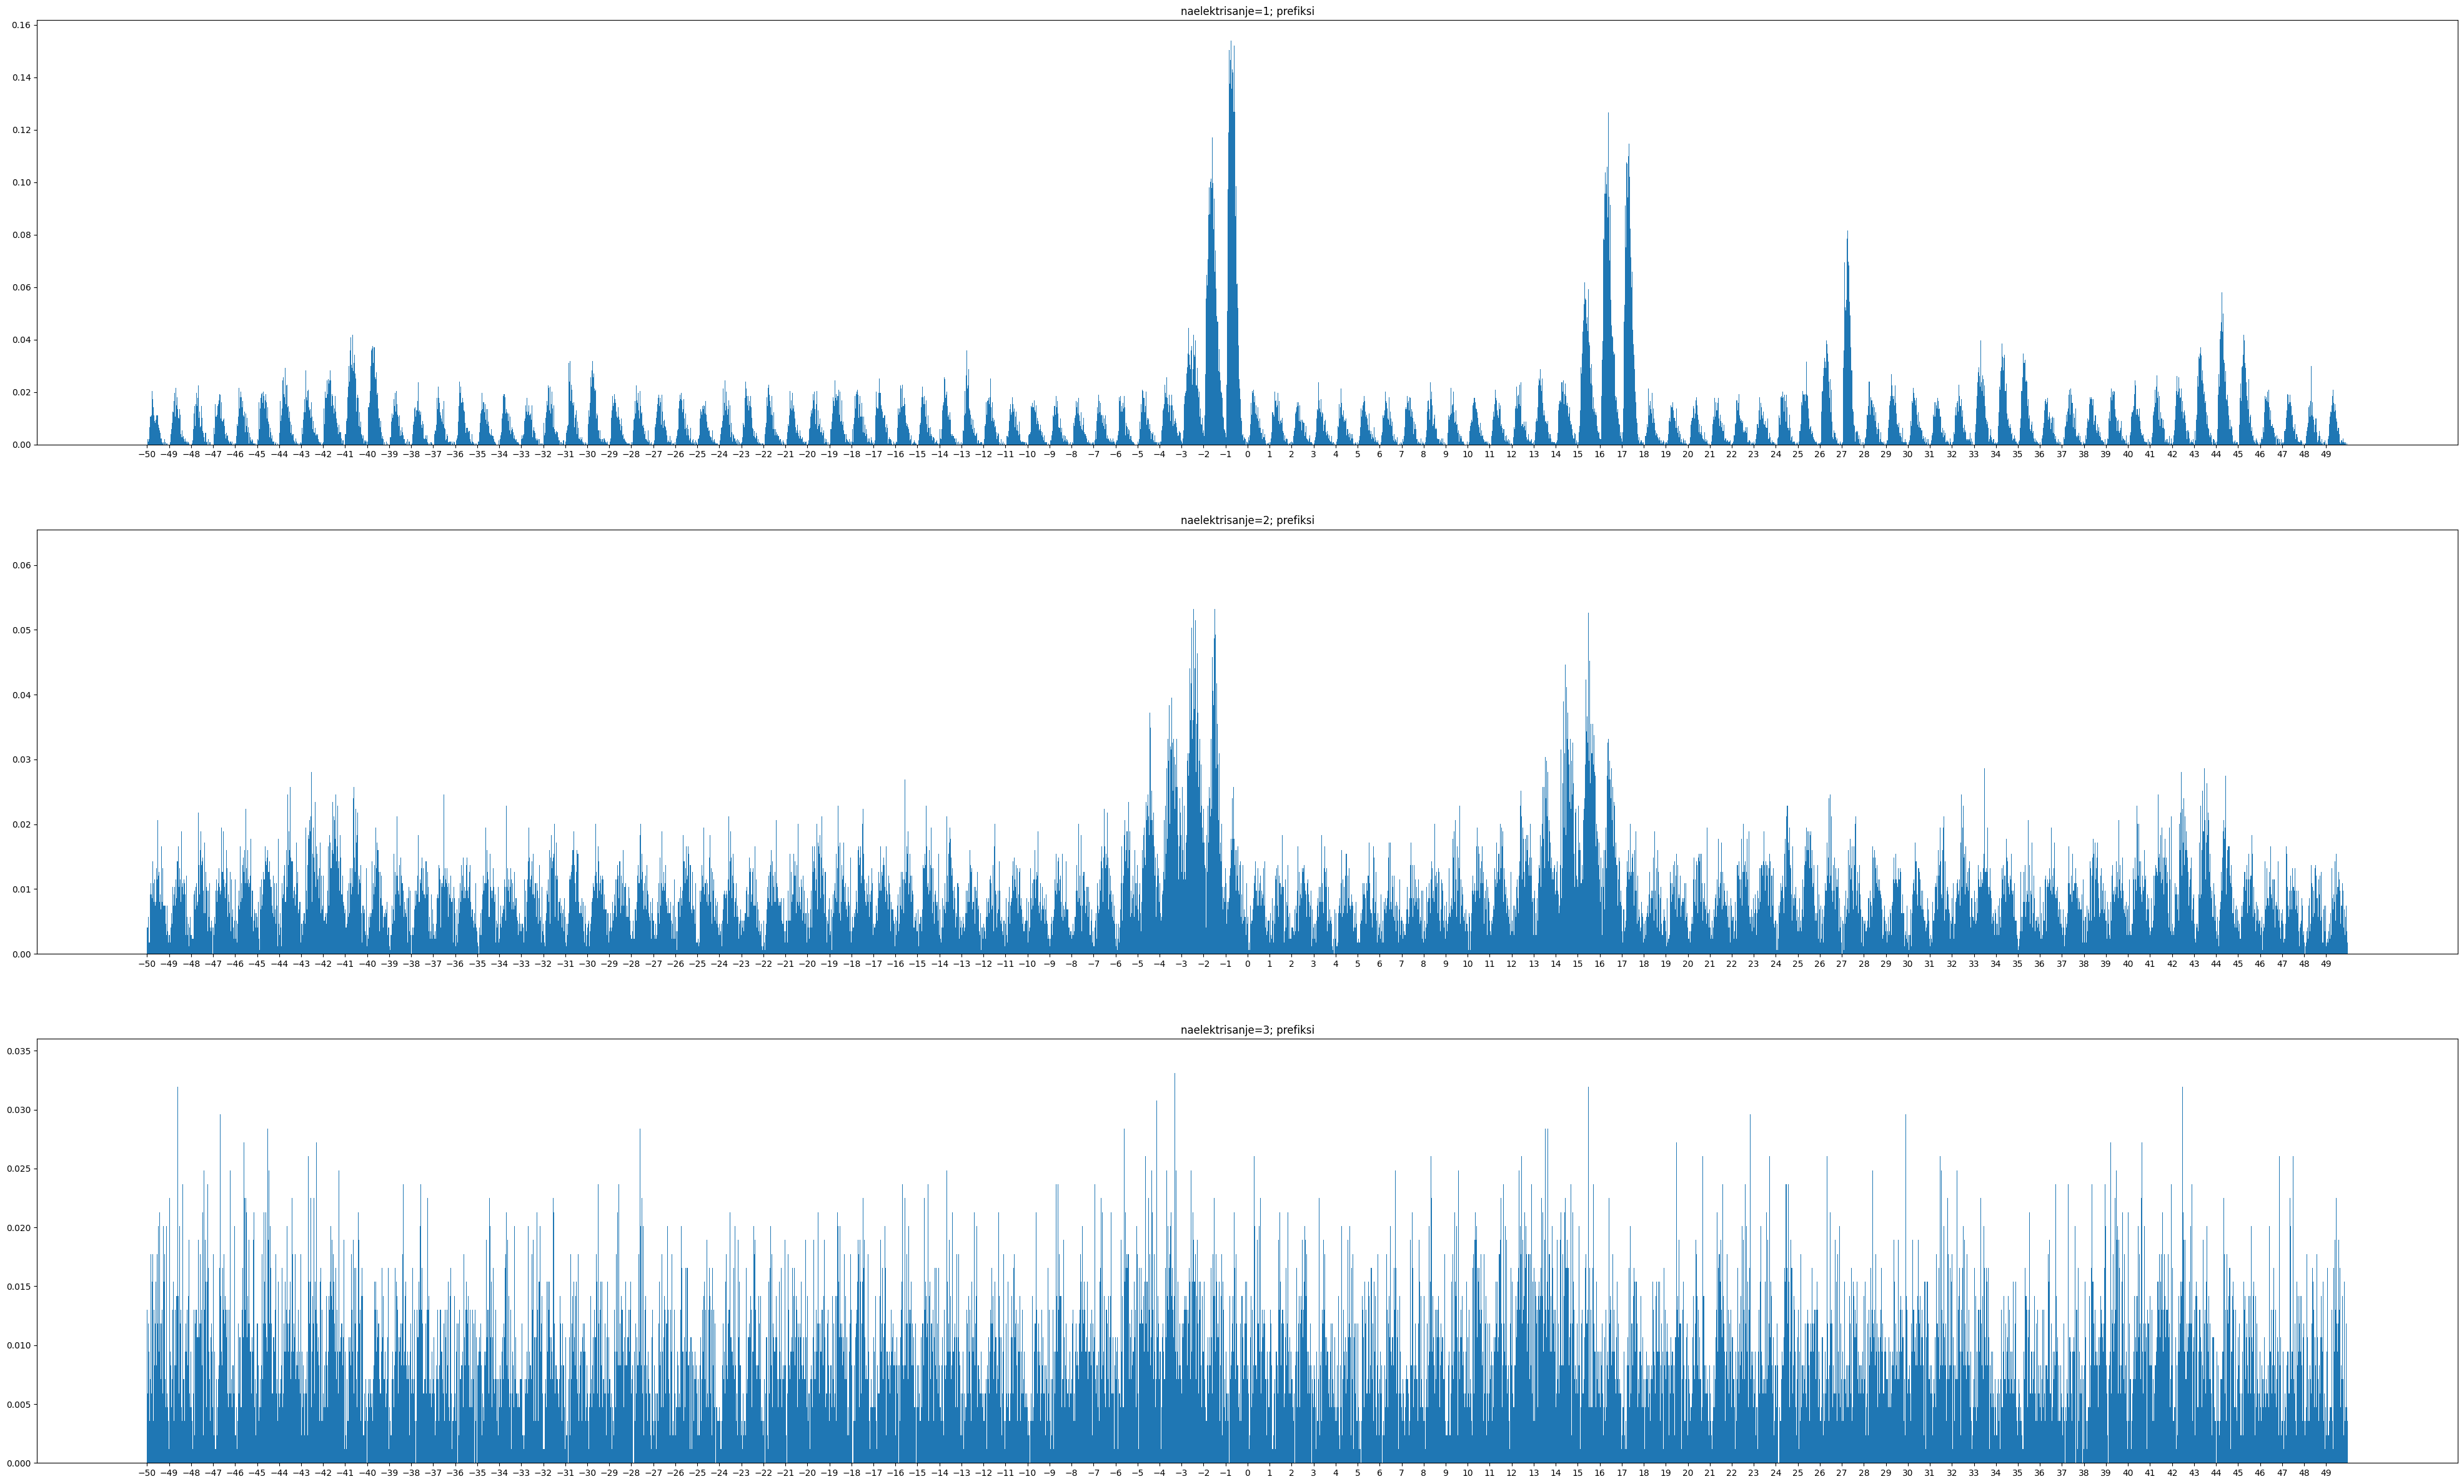

1806603

In [63]:
trening_skup.funkcija_ucestalosti_pomeraja(naelektrisanja=[1,2,3], prefiks=True)
gc.collect()

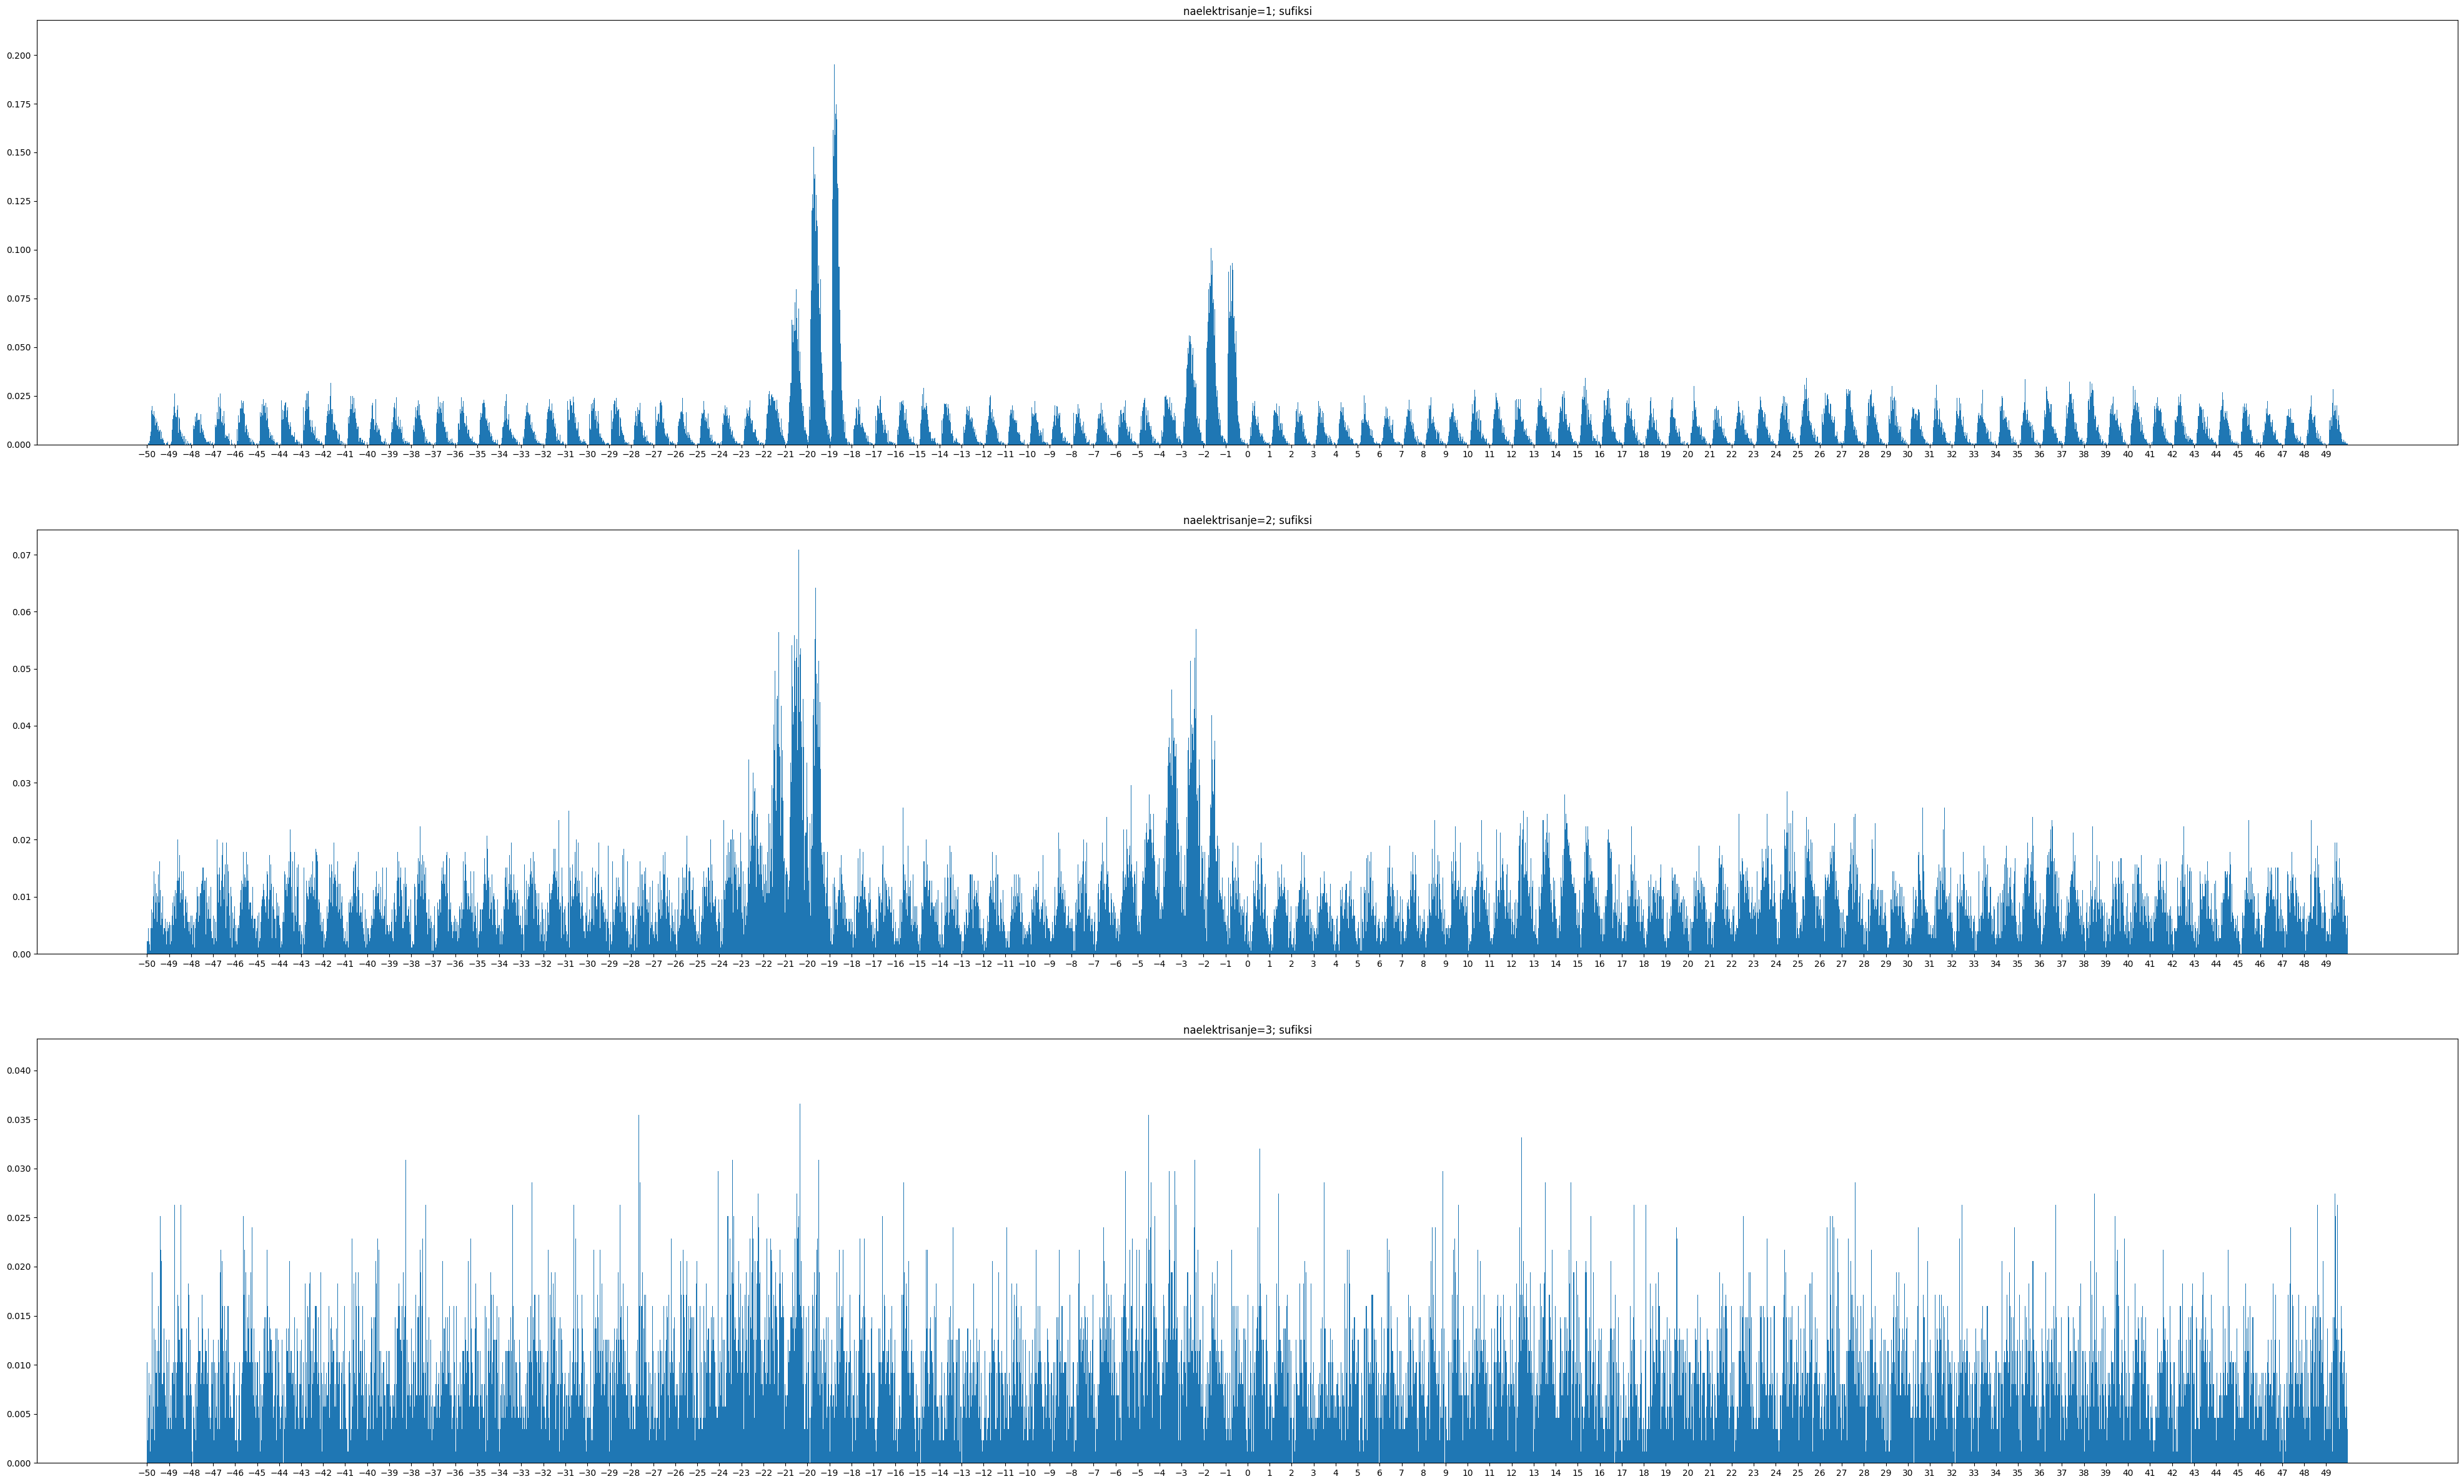

1806802

In [64]:
trening_skup.funkcija_ucestalosti_pomeraja(naelektrisanja=[1,2,3], prefiks=False)
gc.collect()

In [437]:
#TODO: implementirati da bude automatski

izdvojeni_prefiksni_joni = np.array([1.006, -17.005, -16.021, -26.988, -34.031, -44.015]) # * -1
izdvojeni_sufiksni_joni = np.array([19.020, 1.005, 1.989]) # * -1

prefiksni_joni = np.array([1, -17, -16, -27, -34, -44]) # np.array([1])
sufiksni_joni = np.array([-19, 2]) # np.array([-19])

## Korekcija roditeljske mase

1. plotovanje offseta izmedju eksperimentalno opazene roditeljske mase i m(P)
2. offseta izmedju kombinatorno izracunate roditeljske mase i m(P) 

In [438]:
""" TODO: fix this """
def korekcija_roditeljske_mase(peptid, spektar, prefiksni_joni, sufiksni_joni):

    preciznost = 1
    c = dict({})
    zbir_udaljenosti = dict({})
    m_z = spektar.m_z

    for x in np.arange(spektar.roditeljska_masa-50, spektar.roditeljska_masa+50, 1):
        refleksija_spektra = []

        for p_jon in prefiksni_joni:
            for s_jon in sufiksni_joni:
                d = s_jon - p_jon

                for s in m_z:
                    refleksija_spektra.append(x - s - d)

        c[int(x)] = 0
        zbir_udaljenosti[int(x)] = 0

        for si in m_z:
            for sj in refleksija_spektra:
                c[int(x)] += 1 if abs(si-sj) <= preciznost else 0
                zbir_udaljenosti[int(x)] += abs(si-sj) if abs(si-sj) <= preciznost else 0

    c_df = pd.DataFrame(c.items(), columns=["x","broj_pojavljivanja"])
    zbir_udaljenosti_df = pd.DataFrame(zbir_udaljenosti.items(), columns=["x","zbir_udaljenosti"])
    df = c_df.merge(zbir_udaljenosti_df, how="inner", on="x")

    najveci_broj_pojavljivanja = df.loc[df["broj_pojavljivanja"] == df.loc[df.idxmax()["broj_pojavljivanja"], "broj_pojavljivanja"]]
    korigovana_masa = najveci_broj_pojavljivanja.loc[najveci_broj_pojavljivanja.idxmin()["zbir_udaljenosti"], "x"]

    print(f"Roditeljska masa spektra: {spektar.roditeljska_masa}; Masa peptida: {round(peptid.masa, 2)}; Korigovana masa: {round(korigovana_masa, 2)}")

In [440]:
for i in range(1):
    peptid, spektar = trening_skup.peptidi_i_spektri[i]
    korekcija_roditeljske_mase(peptid, spektar, prefiksni_joni, sufiksni_joni)

Roditeljska masa spektra: 1283.664; Masa peptida: 1264; Korigovana masa: 1285


### Odredjivanje verovatnoca tipova jona na osnovu trening skupa

* n-1 lokacija na kojoj se moze pojaviti b-jon
* n-1 lokacija na kojoj se moze pojaviti y-jon

---> broj lokacija na kojima se moze pojaviti odredjen tip jona se razlikuje shodno masama koje mogu biti opazene koriscenjem masenog spektra (postoji donji, kao i gornji limit).

In [66]:
broj_pozicija = dict()
broj_pozicija["b"] = 0
broj_pozicija["y"] = 0

broj_odgovarajucih = dict()
broj_odgovarajucih["b"] = 0
broj_odgovarajucih["y"] = 0

for i in range(0,len(trening_skup.peptidi_i_spektri)):    
    peptid = trening_skup.peptidi_i_spektri[i][0].peptid
    spektar = trening_skup.peptidi_i_spektri[i][1].mase_intenziteti
    
    duzina_peptida = len(peptid)
    broj_pozicija["b"] += (duzina_peptida-2)
    broj_pozicija["y"] += (duzina_peptida-2)
    
    for j in range(1, duzina_peptida-1):
        prefiks = Peptid(peptid[0:j]).masa + 1.006
        sufiks = Peptid(peptid[j:]).masa + 19.020
        
        broj_odgovarajucih["b"] += len(spektar[(spektar["m_z"] >= prefiks-0.5) & (spektar["m_z"] <= prefiks + 0.5)])
        broj_odgovarajucih["y"] += len(spektar[(spektar["m_z"] >= sufiks-0.5) & (spektar["m_z"] <= sufiks + 0.5)])
    
display(f"Broj pozicija: {broj_pozicija['b']}; Broj odgovarajucih pikova: {broj_odgovarajucih['b']}; Verovatnoca = {round(broj_odgovarajucih['b']/broj_pozicija['b'],5)}")
display(f"Broj pozicija: {broj_pozicija['y']}; Broj odgovarajucih pikova: {broj_odgovarajucih['y']}; Verovatnoca = {round(broj_odgovarajucih['y']/broj_pozicija['y'],5)}")

'Broj pozicija: 40678; Broj odgovarajucih pikova: 16957; Verovatnoca = 0.41686'

'Broj pozicija: 40678; Broj odgovarajucih pikova: 20258; Verovatnoca = 0.49801'

In [67]:
verovatnoca = dict()
verovatnoca["b"] = 0.41686
verovatnoca["y"] = 0.49801

In [68]:
# raspodela = {offset: probability}
raspodela = dict()

def skorovanje(raspodela):
    pass

### Проблем симетричних путања

## Идентификација пептида

* korektan peptid obicno ne postize najveci skor medju svim peptidima
* ali obicno postize medju svim peptidima ogranicenim na preoteom vrste
* tako prelazimo sa problema skevenciranja na problem identifikacije peptida ogranicavajuci problem i pretragu na peptide prisutne u proteomu (konkateniramo ih u jedan string amino kiselina Proteome)

### Zasto se vracamo na problem identifikacije peptida, s obzirom da nam proteom некада nije poznat?

* priblizno 90% proteina koji cine zivotinjske kosti jesu **kolageni**
* provera u odnosu na celu Uniprot bazu (koja sadrzi hiljade vrsta, sto cini ukupno 200 miliona amino kiselina) + mutirane verzije kolagena vrsta  (UniProt+)

#### Kako testiramo da li je peptid koji smo pronasli zapravo korektna interpretacija datog spektra?
=> peptide-spectrum matches (PSMs)

In [69]:
def pronadji_peptid_sa_maksimalnim_skorom(spektralni_vektor, proteom):
    pass

In [70]:
spektralni_vektori = []
proteom = ""
prag_skora = 0

# PSM_threshold_(Proteome, SpectralVectors)
poklapanja_peptida_i_spektra = []

for spektralni_vektor in spektralni_vektori:
    peptid, skor = pronadji_peptid_sa_maksimalnim_skorom(spektarlni_vektor, proteom)
    if skor >= prag_skora:
        poklapanja_peptida_i_spektra.append((peptid,skor))

<pre> 
Da li milijarde peptida koje se ne pojavljuju u bazi podataka i koje prevazilaze skor peptida koji smo mi odabrali, implicira da je baza zapravo nekompletna i da je spektar nastao od nekog drugog peptida?

=> najbolje ocenjen peptid proteome najcesce bude premasen skorovima milijardi peptida koji ne pripadaju proteomu. Medjutim, ovaj fenomen ne implicira da je PSMSearch identifikovao pogresan peptid, jer ukupan broj peptida sa istom masom moze da se meri u trilionima ili cak kvadrilionima. Drugim recima, milijarde peptida koji prevazilaze izabrani peptid predstavljaju mali deo svih peptida koji imaju jednaku masu kao on. Stog, potrebno nam je da evauliramo statisticku znacajnost pronadjednog PSM-a.

</pre>

## Бесконачна теорема мајмуна

<pre>
Lazni (Decoy) proteom = slucajno generisana niska amino kiselina jednake duzine kao Proteom (sa verovatnocom generisanja svake amino kiseline na svakoj poziciji jednakoj 1/20).

=> Resavamo problem pronalazenja PSM-a za Lazni proteom, umesto za stvarni, koristeci isti prag skora.
Nismo zainteresovani za PSM-ove pronadjene u tom resenju, jer oni predstavljaju samo bioloski nerelevantne artifakte.
<b> Poenta </b> je da broj pronadjenih PSM-ova pruza grubu estimaciju broja pogresnih PSM-ova identifikovanih u nasem bioloski <b> relevantnoj </b> pretrazi u odnosu na stvarni proteom. 

</pre>

<pre>
Cak iako je FDR visok, ne bi trebalo da zakljucimo da je spektralni skup beskorisan, ili da pretrazujemo u pogresnoj bazi: moze se desiti da smo jednostavni izabrali pogresan prag skora za analizu nasih podataka, s obzirom na to FDR veoma varira u zavisnosti od izbora praga.

</pre>

<pre>

FDR nam pomaze da analiziramo ceo skup identifikovanih PSM, ali sta je sa statistickom znacajnoscu individualnog PSM-a? 

Mozemo li da odredimo da li je PSM(peptid, spektralni_vektor) statisticki znacajn? 
Prvo moramo da kvantifikujemo sta znaci <b>statisticki znacajno</b>.


<b>Dictionary</b> - skup niski
<b>E(Dictionary,n)</b> - ocekivani broj pojavljivanja niski iz recnika u slucajno generisanoj nisci duzine <b>n</b>, gde su verovatnoce generisanja svakog slova na svakoj poziciji niske jednake. 

Let EnglishDictionary denote the set of all English words. If it turns out that,
after typing n symbols, the monkey types significantly more English words than
E(EnglishDictionary, n), then we have every reason to believe that the monkey can
spell! On the other hand, if the monkey types about the same number of words as
E(EnglishDictionary, n), then the monkey is probably not Shakespeare reincarnate.
</pre>

In [71]:
import string
import random

slova = string.ascii_lowercase
slova

'abcdefghijklmnopqrstuvwxyz'

In [72]:
''.join(random.choices(slova, k=4))

'zuip'

<i>Given a set of strings Dictionary, we define E(Dictionary, n) as the expected number
of occurrences of strings from Dictionary in a randomly generated string of length n,
where the probabilities of generating every letter at each position of the string are
the same.</i>

In [73]:
recnik = []
n = 0

def ocekivani_broj(recnik,n):
    slucajno_generisana_niska = ''.join(random.choices(slova, k=n))
    pass

<pre>
Spektralni recnik - skup peptida sa visokim skorom (preko praga): Dictionary_threshold(Spectrum)

PSM recnik - recnik za odredjeni par Peptid, SpektralniVektor, oznacavacemo ga sa Dictionary(Peptid, SpektralniVektor)
</pre>


<pre>
Trazimo poklapanja peptida iz spektralnog recnika u odnosu na proteom. Ako pronadjemo poklapanje, onda treba da odlucimo da li ono predstavlja bioloski validne PSM-ove, ili samo statisticke artifakte. 
Da bi doneli takvu odluku, razmatramo:
</pre>
<pre>
^^ sto predstavlja ocekivani broj peptida u decoy proteomu duzine n koji bi se pojavio u ovom recniku (sa skorom >= prag_skora).
Ako je broj > 1 onda nema nista iznenadjujuce u pronalasku peptida koji ima postize skor prag_skora u odnosu na SpektralniVektor. 
</pre>



<pre>
Koliko puta ocekujemo da se Peptid pojavi u DecoyProteom
Radimo procenu za svaki od peptida
</pre>
<pre>
Mozemo da koristimo aproksimaciju:
</pre>


In [74]:
def ocekivani_broj_visoko_skorovanih_peptida(spektralni_vektor, prag, n):
    return "E(Dictionary_threshold(Spectrum), n)"

In [75]:
spektralni_vektor = [0,4,-3,-2,3,3,-4,5,-3,-1,-1,3,4,1,3]
len(spektralni_vektor)

15

In [76]:
sum([x for x in spektralni_vektor if x > 0])

26

In [77]:
broj_kolona = len(spektralni_vektor)
broj_redova = sum([x for x in spektralni_vektor if x > 0])
velicina = np.array([[0] * broj_redova] * broj_kolona)
velicina[0][0] = 1

In [78]:
velicina

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [79]:
def izracunaj_velicinu(spektralni_vektor, masa, skor): # Size(i,t)
    if masa < 0:
        return 0
    
    if masa == 0 and skor == 0:
        return 1 
    
    if masa == 0:
        return 0
    
    akm = {
        "X": 4,
        "Z": 5
    }
    
    return sum([izracunaj_velicinu(spektralni_vektor, masa=masa-akm[a_k], skor=skor-spektralni_vektor[masa]) for a_k in akm])

In [80]:
izracunaj_velicinu(spektralni_vektor, 14, 5)

3

dimenzije matrice: 16 x 6 

In [81]:
# TODO: implemetirati pomocu dinamickog programiranja
akm = {
    "X": 4,
    "Z": 5
}

def izracunaj_velicinu(spektralni_vektor):
 
    masa = len(spektralni_vektor)
    minimalan_skor = sum([x for x in spektralni_vektor if x < 0])
    maksimalan_skor = sum([x for x in spektralni_vektor if x > 0])
   
    # Inicijalizacija matrice memo
    memo = [[0 for j in range(minimalan_skor, maksimalan_skor+1)] for i in range(masa)]
    memo[0][0] = 1
    
    # Popunjavanje matrice memo
    for i in range(1, masa):
        for j in range(minimalan_skor, maksimalan_skor+1):
            #print(i, j-spektralni_vektor[i])
            memo[i][j] = sum(
                [memo[i-akm[a_k]][j-spektralni_vektor[i]] \
                if (i-akm[a_k] >= 0 and \
                    j-spektralni_vektor[i] >= 0 and \
                    j-spektralni_vektor[i] <= maksimalan_skor and \
                    j-spektralni_vektor[i] >= minimalan_skor) \
                else 0 \
                for a_k in akm])
            
    return memo

<pre>
i = 6, j = 2

Pukao za:
i-akm[a_k] = 2, j-spektralni_vektor[i] = 6

Jer ne postoji memo lokacija sa tim indeksima. 
Okej, dakle razlog sto nam puca je sto nije doovoljno da matricu popunimo do vrednosti skor, jer postoje vece vrednosti od te: dakle moramo da nadjemo maksimalnu vrednost skora i da matricu popunjavamo do te dimenzije (zasto? jer je moguce da imamo skor t, i da imamo negativnu vrednost u spektralnom vektoru koja ce nam vratiti manji skor, pa zbog toga ne mozemo da ogranicimo samo do vrednosti skora, vec do maksimalne moguce)
</pre>

In [82]:
velicina = izracunaj_velicinu(spektralni_vektor)

In [83]:
display(velicina[14][5])

3

In [84]:
def velicina_spektralnog_recnika(spektralni_vektor, prag):
    
    masa = len(spektralni_vektor)-1
    maksimalan_skor = sum([x for x in spektralni_vektor if x > 0])
    velicina = izracunaj_velicinu(spektralni_vektor)
    
    return sum([velicina[masa][skor] for skor in range(prag, maksimalan_skor+1)])

In [85]:
velicina_spektralnog_recnika(spektralni_vektor, 5)

3

In [86]:
def izracunaj_verovatnocu(spektralni_vektor):
 
    masa = len(spektralni_vektor)
    minimalan_skor = sum([x for x in spektralni_vektor if x < 0])
    maksimalan_skor = sum([x for x in spektralni_vektor if x > 0])
   
    # Inicijalizacija matrice memo
    memo = [[0 for j in range(minimalan_skor, maksimalan_skor+1)] for i in range(masa)]
    memo[0][0] = 1
    
    # Popunjavanje matrice memo
    for i in range(1, masa):
        for j in range(minimalan_skor, maksimalan_skor+1):
            #print(i, j-spektralni_vektor[i])
            memo[i][j] = 1.0/20 * sum(
                [memo[i-akm[a_k]][j-spektralni_vektor[i]] \
                if (i-akm[a_k] >= 0 and \
                    j-spektralni_vektor[i] >= 0 and \
                    j-spektralni_vektor[i] <= maksimalan_skor and \
                    j-spektralni_vektor[i] >= minimalan_skor) \
                else 0 \
                for a_k in akm])
            
    return memo

In [87]:
def verovatnoca_spektralnog_recnika(spektralni_vektor, prag):
    
    masa = len(spektralni_vektor)-1
    maksimalan_skor = sum([x for x in spektralni_vektor if x > 0])
    verovatnoca = izracunaj_verovatnocu(spektralni_vektor)
    
    return sum([verovatnoca[masa][skor] for skor in range(prag, maksimalan_skor+1)])

In [88]:
verovatnoca_spektralnog_recnika(spektralni_vektor, 5)

0.0003750000000000001

<pre>
Formula: 
<b>n * verovatnova_spektralnog_recnika(spektralni_vektor, prag)</b>
predstavlja ocekivan broj pojavljivanja peptida iz recnika u slucajno generisanom proteomu duzine n (duzina n je uzeta kao duzina baze koju pretrazujemo u potrazi za peptidom)
</pre>

## Zagonteka hemoglobina

## Post-translacione modifikacije

* mutacije peptida
* pronalazenje peptida sa najvecim skorom i sa najvise **k** mutacija
* broj mutiranih peptida je ogroman (ako bismo mutirali svaku mogucu poziciju i kreirali Mutirani Proteom); cak i ako bismo dozvolili samo jednu mutaciju po peptidu
* pstm - menjaju amino kiseline nakon translacije proteina iz RNA (dodavanje/uklanjanje fosfatne grupe na odredjenoj amino kiselini, proces znan kao fosforilacija)

### Problem poravnanja

* modifikacije mase <i>d</i>
* uvodimo termin "block indel"
<pre>
If d is positive, then the resulting modified peptide has a peptide vector that differs from the original peptide vector Peptide by inserting a block of d zeroes before the i-th occurrence of 1 in Peptide. In the more rare case that d is negative, the modified peptide corresponds to deleting a block of |d| zeroes from Peptide.
</pre>

### Izgradnja Menhetn mreze za spektralno poravnanje

<pre>
Modifikacija mase <i>d</i> primenjena na amino kiselinu rezultuje dodavanjem d na masu amino kiseline.
d = 80: fosforilacija
d = 16: prolin --> hidroksiprolin
d = -1: lizin --> alizin
</pre>